# Machine Learning project 2023/2024
### Elena Lippolis 252310

Importing the libraries

In [24]:
!pip install umap-learn
!pip install statsmodels
import statsmodels.api as sm


import umap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

import numpy as np
from scipy.stats import f
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pyclustering.cluster.kmedoids import kmedoids # Only for Windows, add a '#' before it if you're using an Apple computer.
from pyclustering.cluster.kmedoids import kmedoids as kmedoids_clustering
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils.metric import distance_metric, type_metric
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor

from sklearn.metrics import silhouette_score

import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import sklearn
import scipy
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import t
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import classification_report, roc_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


You should consider upgrading via the '/home/elena/Desktop/ML-project0/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/elena/Desktop/ML-project0/venv/bin/python -m pip install --upgrade pip' command.


# 1. Preliminary analysis
Perform a preliminary analysis on the data. For instance, but not lim-
ited to, visualize samples, identify if features (i.e., codon frequencies) are
correlated, determine which are most correlated with the target classes,
and inspect the distribution of samples among classes. Using clustering,
study if there are structures in the data that allow samples from different
classes (both DNA type and Kingdom) to be easily identified. Compare
the performance of different clustering algorithms and distance measures
using the metrics presented during the course.

### 1. Data loading and initial exploration

In [2]:
# Read the data creating a pandas dataFrame
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
# Remove the first column (Unnamed: 0)
test_data.drop(columns=test_data.columns[0], axis=1, inplace=True)
train_data.drop(columns=train_data.columns[0], axis=1, inplace=True)
# Print the first rows of the dataset
print(test_data.head())

  Kingdom  DNAtype  SpeciesID  Ncodons                          SpeciesName  \
0     bct        0     360105   568103          Campylobacter curvus 525.92   
1     inv        0     135724     6295                Pimpla hypochondriaca   
2     pln        0     120297     3451     Fusarium oxysporum f. sp. niveum   
3     pln        0     105351    14867                  Aspergillus awamori   
4     pln        2     280810     1143  chloroplast Cryptothallus mirabilis   

       UUU      UUC      UUA      UUG      CUU  ...      CGA      CGG  \
0  0.00959  0.01359  0.01584  0.01312  0.02491  ...  0.00354  0.00121   
1  0.01223  0.03447  0.00508  0.01811  0.01176  ...  0.00763  0.00524   
2  0.01014  0.03014  0.00145  0.01275  0.01420  ...  0.00551  0.00058   
3  0.03551  0.02892  0.00155  0.01117  0.01224  ...  0.00303  0.00451   
4  0.01662  0.01400  0.02800  0.03412  0.01312  ...  0.01662  0.00175   

       AGG      GAU      GAC      GAA      GAG      UAA      UAG      UGA  
0  0.00709

### 2. Visualize class distributions

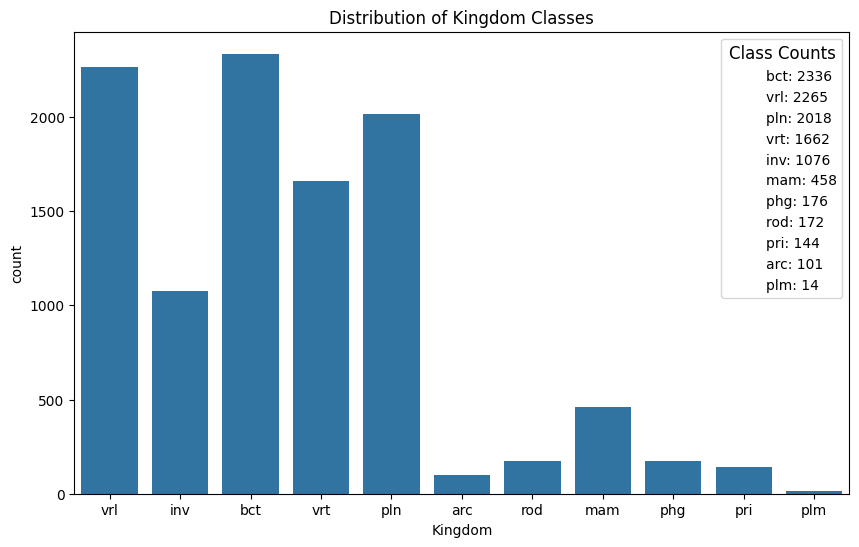

In [3]:
kingdom_counts = train_data['Kingdom'].value_counts()

# Plot distribution of Kingdom
plt.figure(figsize=(10, 6))
sns.countplot(x='Kingdom', data=train_data)
plt.title('Distribution of Kingdom Classes')

# Create a legend with class counts
legend_labels = [f'{kingdom}: {count}' for kingdom, count in kingdom_counts.items()]
handles = [plt.Line2D([0], [0], color='white', label=label) for label in legend_labels]
plt.legend(handles=handles, title="Class Counts", loc='upper right', fontsize='medium', title_fontsize='large')

plt.show()

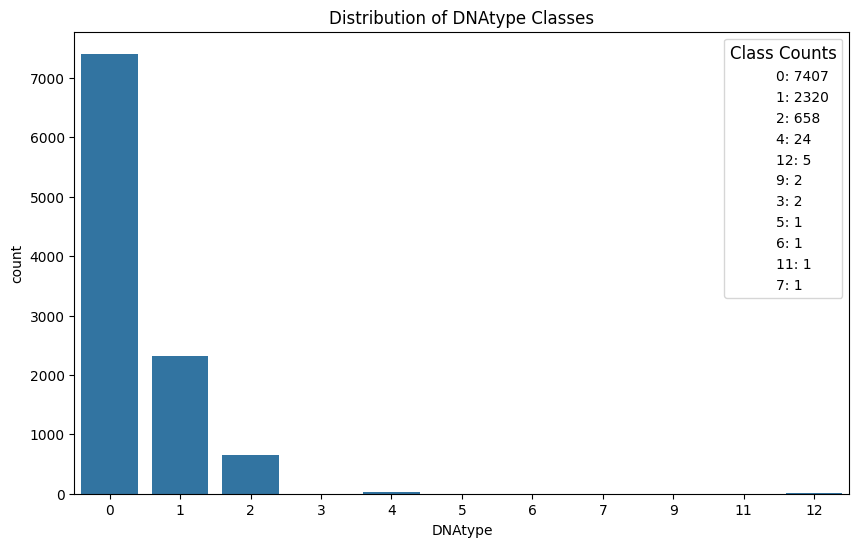

In [4]:
# Visualize distribution of DNAtype
DNAtype_counts = train_data['DNAtype'].value_counts()

# Plot distribution of DNAtype
plt.figure(figsize=(10, 6))
sns.countplot(x='DNAtype', data=train_data)
plt.title('Distribution of DNAtype Classes')


# Create a legend with class counts
legend_labels = [f'{DNAtype}: {count}' for DNAtype, count in DNAtype_counts.items()]
handles = [plt.Line2D([0], [0], color='white', label=label) for label in legend_labels]
plt.legend(handles=handles, title="Class Counts", loc='upper right', fontsize='medium', title_fontsize='large')

plt.show()

### 3. Pairplot for feature relationships
Creates a pair plot to visualize the relationships between "DNAtype", "SpeciesID" and "Ncodons", coloring the data points by "Kingdom".

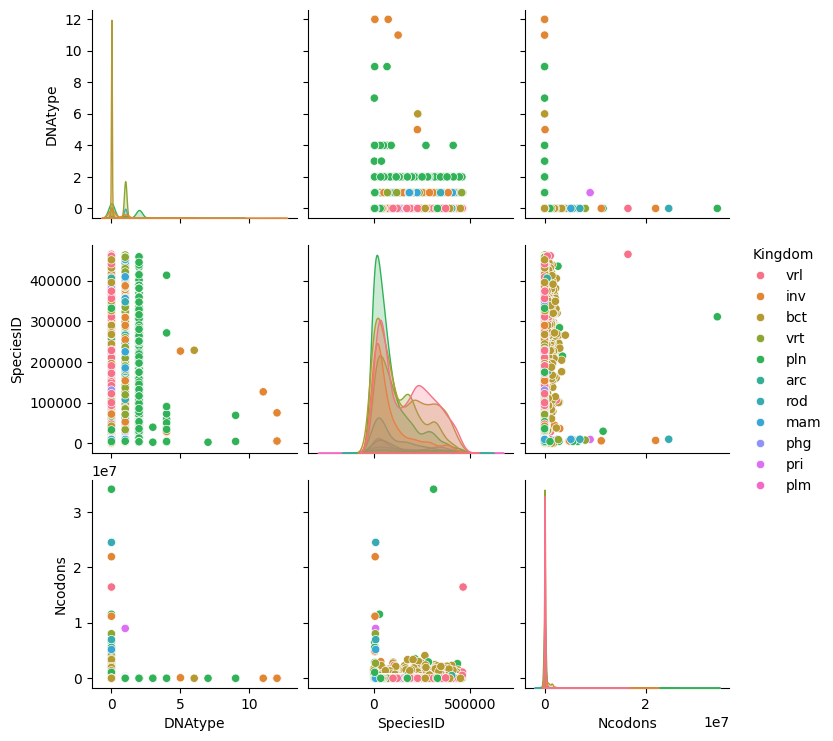

In [5]:
# Plot a pair plot showing the DNAtype, SpeciesID and Ncodons variables vs each other
# with Kingdom as a hue, using seaborn pairplot utility
train_data = train_data[['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons']]
sns.pairplot(train_data, hue='Kingdom')

### 4. Correlation analysis
Plots the heatmap to visualize the correlations between features.

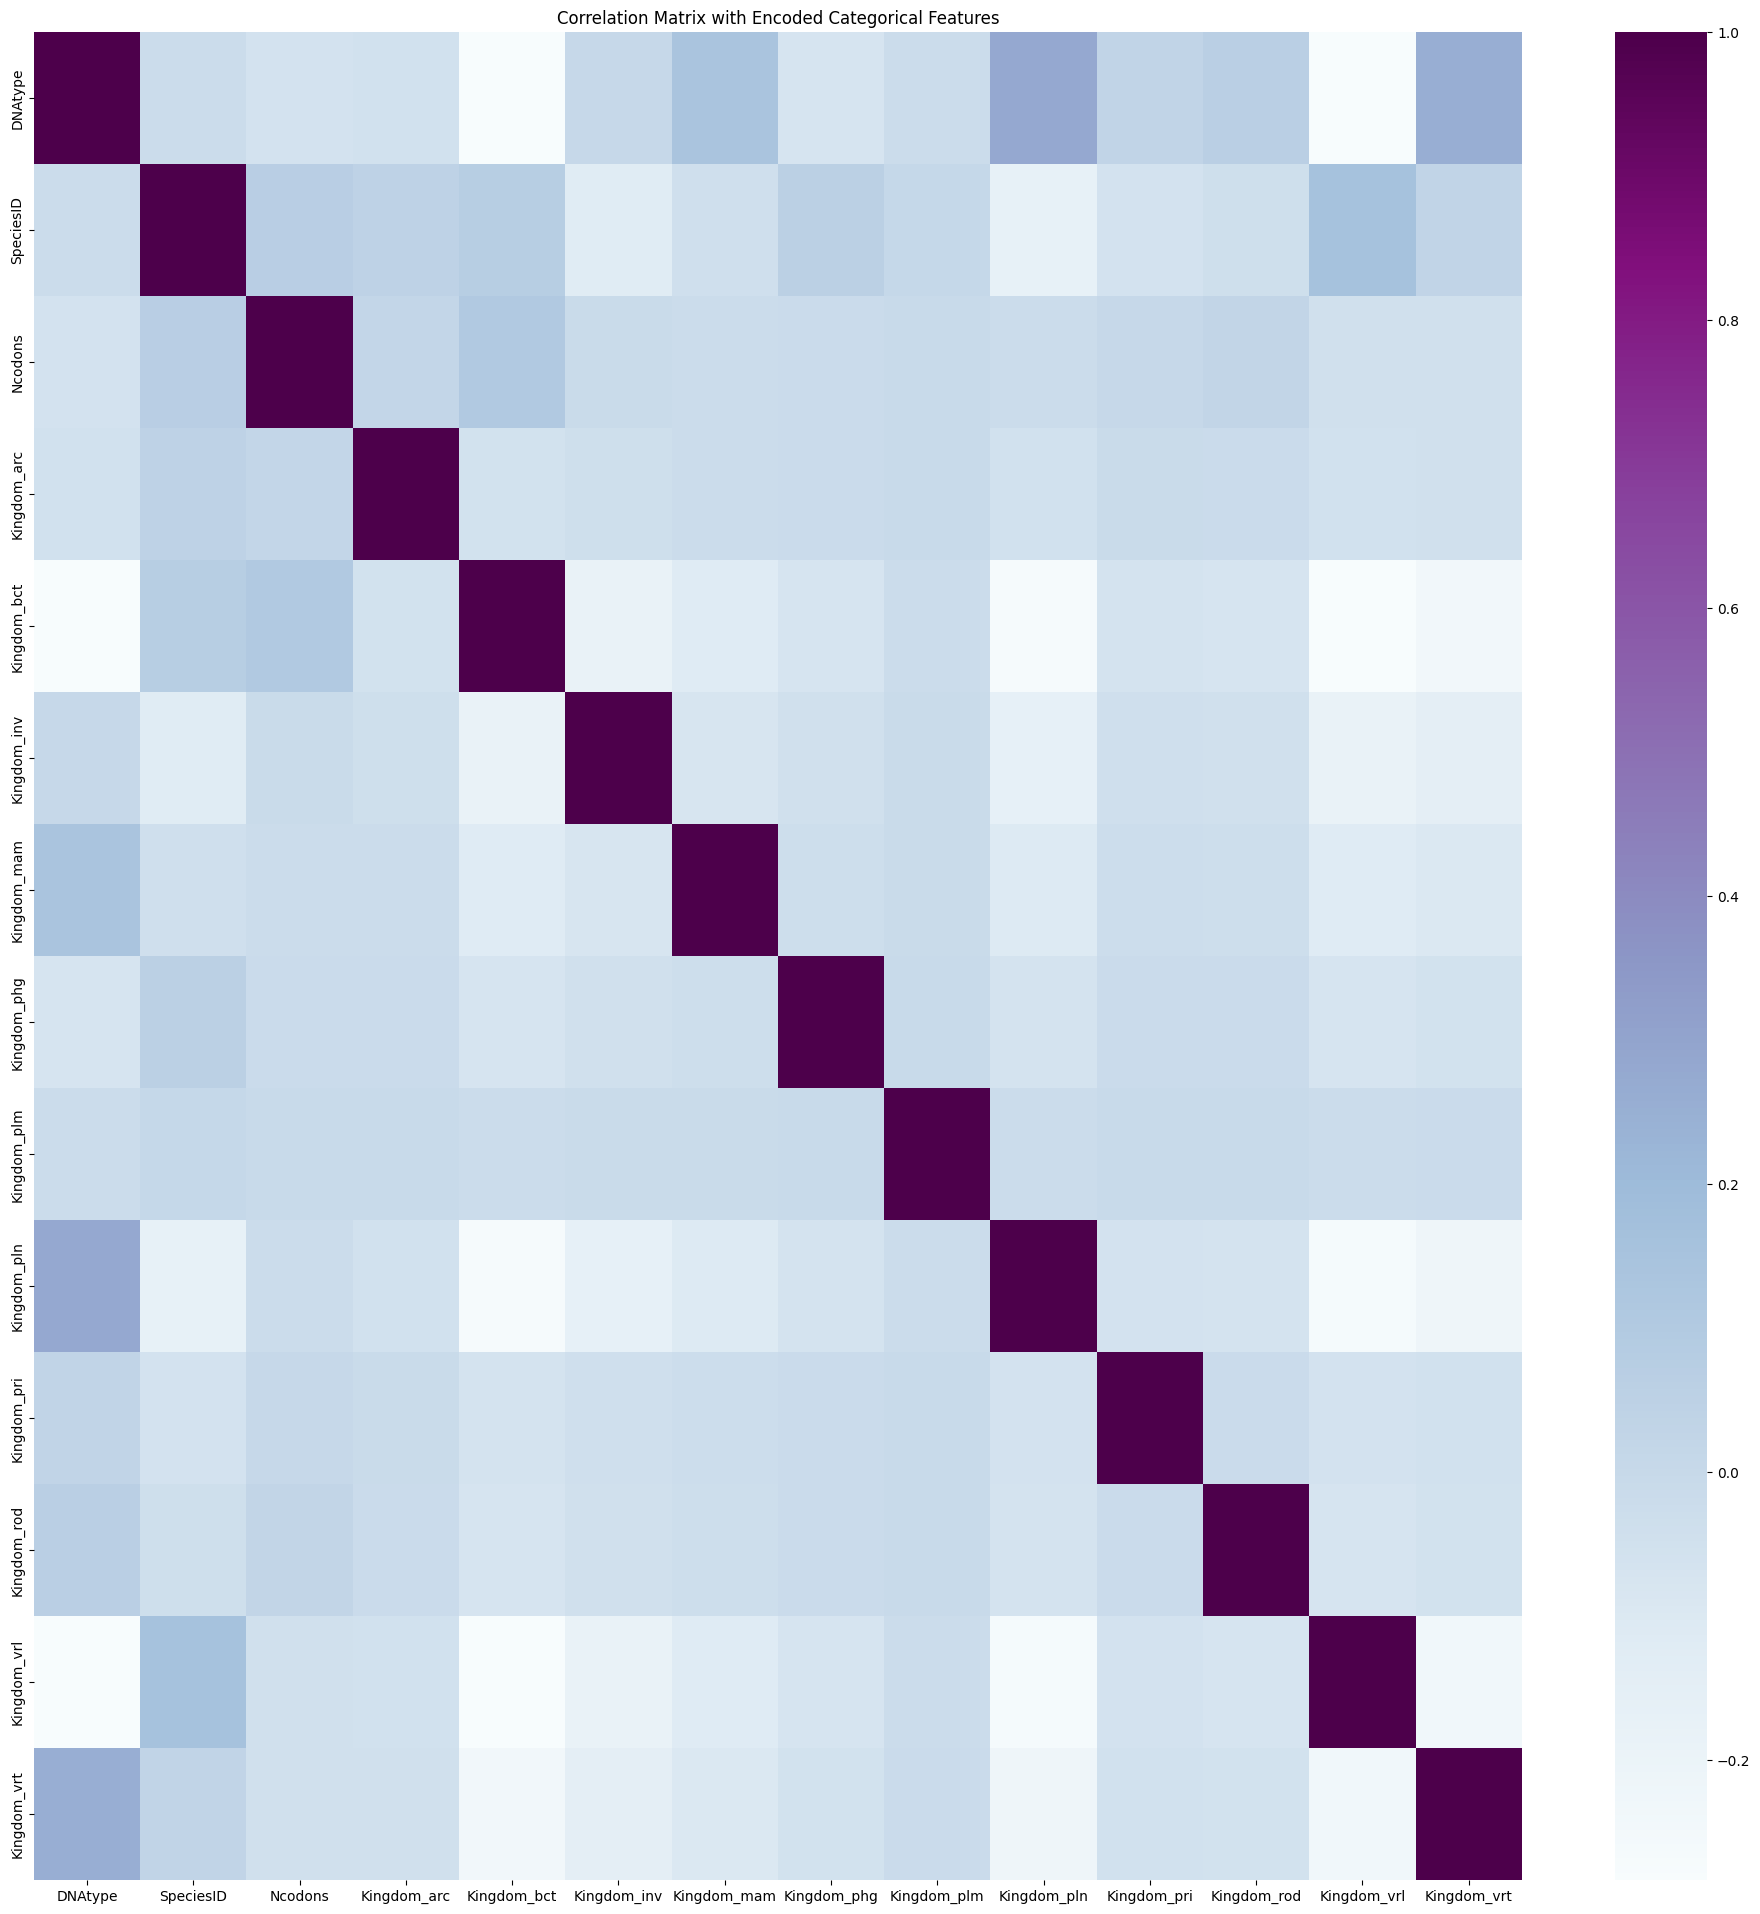

In [6]:
# Convert categorical variables to numerical (get_dummies)
# Remove SpeciesName; axis = 1 specifies we want to drop a column (drop)
encoded_data = pd.get_dummies(train_data)
# Correlation matrix and heatmap
# Correlation matrix show how each feature is correlated with every other feature
corr_matrix = encoded_data.corr()
# Plot the heatmap
plt.figure(figsize=(24, 24))
sns.heatmap(corr_matrix, annot=False, cmap='BuPu')
plt.title('Correlation Matrix with Encoded Categorical Features')
plt.show()

### 5. Train-Test split and visualization
In order to measure the true performance of the mode, we usually split the test of available data into the training (tune the model parameters) and test sets (to measure its performance on data never seen during training).
Split the data into training and testing sets, then visualizes them to understand how the data is partitioned and visually inspecting the training and testing distribution over Kingdom.


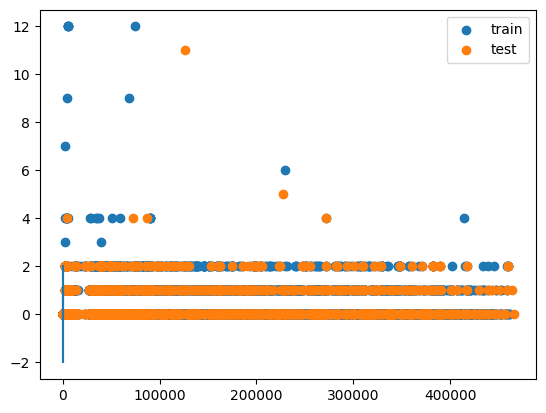

In [7]:
#DNAType
def sample_f(nsamples, minx=0.0, maxx=4.5):
    x = np.linspace(minx, maxx, nsamples)
    y = 2 * np.sin(1.5 * x)
    return x, y
#Set the percentage of the dataset to be used for testing
test_perc = 0.2
#Separate features and target
X_DNAtype = train_data.drop(['Kingdom', 'DNAtype'], axis=1).to_numpy()
y_DNAtype = train_data[['DNAtype']].to_numpy()

#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_DNAtype, y_DNAtype, test_size=test_perc, random_state=42)
#flatten the target arrays
y_train=y_train.squeeze()
y_test=y_test.squeeze()

# Plot the data
plt.scatter(x_train[:, 0], y_train, label='train')
plt.scatter(x_test[:, 0], y_test, label='test')
plt.legend()
tmp_x, tmp_f = sample_f(1000)
plt.plot(tmp_x, tmp_f)

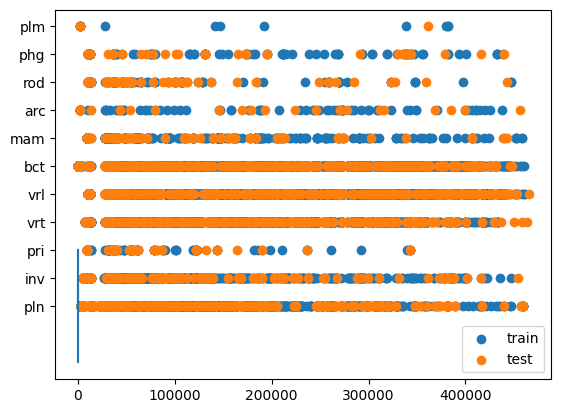

In [8]:
#Kingdom
test_perc = 0.2
X_DNAtype = train_data.drop(['Kingdom', 'DNAtype'], axis=1).to_numpy()
y_DNAtype = train_data[['Kingdom']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X_DNAtype, y_DNAtype, test_size=test_perc, random_state=42)

y_train=y_train.squeeze()
y_test=y_test.squeeze()

# Plot the data
plt.scatter(x_train[:, 0], y_train, label='train')
plt.scatter(x_test[:, 0], y_test, label='test')
plt.legend()
tmp_x, tmp_f = sample_f(1000)
plt.plot(tmp_x, tmp_f)

Determine which features are most correlated with target class

In [9]:
#DNAtype
train_data = pd.read_csv("train.csv")
label_encoder = LabelEncoder()
train_data['Kingdom'] = label_encoder.fit_transform(train_data['Kingdom'])
train_data.drop(['SpeciesName'], axis=1, inplace=True)

#determine correlation
correlations = train_data.corr()['DNAtype'].sort_values(ascending=False)
print(correlations)

DNAtype    1.000000
CGA        0.483252
CUA        0.454410
UGA        0.452418
AUU        0.452203
             ...   
ACG       -0.380136
GUG       -0.436216
AAG       -0.489103
CAG       -0.492103
GAG       -0.493664
Name: DNAtype, Length: 69, dtype: float64


In [10]:
#Kingdom
#Determine which features are most correlated with target class
train_data = pd.read_csv("train.csv")
label_encoder = LabelEncoder()
train_data['Kingdom'] = label_encoder.fit_transform(train_data['Kingdom'])
train_data.drop(['SpeciesName'], axis=1, inplace=True)
#Determine correlation
correlations = train_data.corr()['Kingdom'].sort_values(ascending=False)
print(correlations)


Kingdom    1.000000
CCA        0.417183
ACA        0.375137
CUA        0.356830
UCA        0.309463
             ...   
UCG       -0.282953
ACG       -0.291592
GGC       -0.308203
CCG       -0.381866
GCG       -0.420244
Name: Kingdom, Length: 69, dtype: float64


### 6.  Clustering: data preprocessing and visualization
Load and preprocess data, dimensionality reduction for visualization (PCA and t-SNE), using Kingdom and DNAtype to color the data points

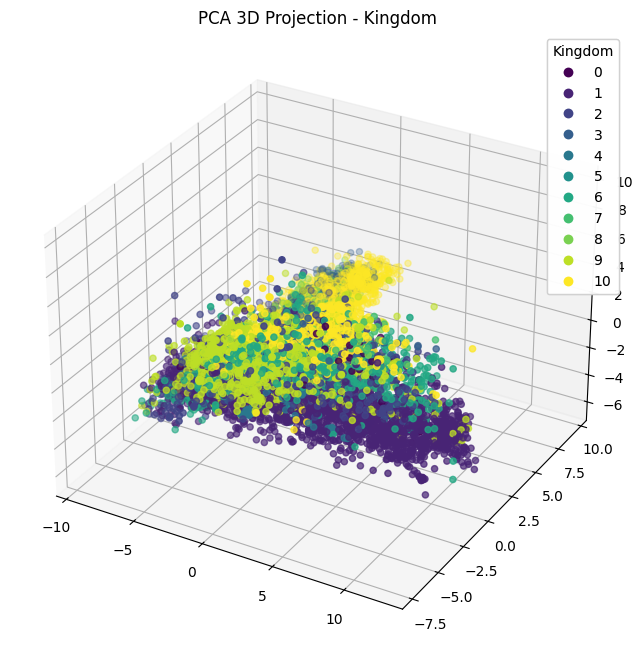

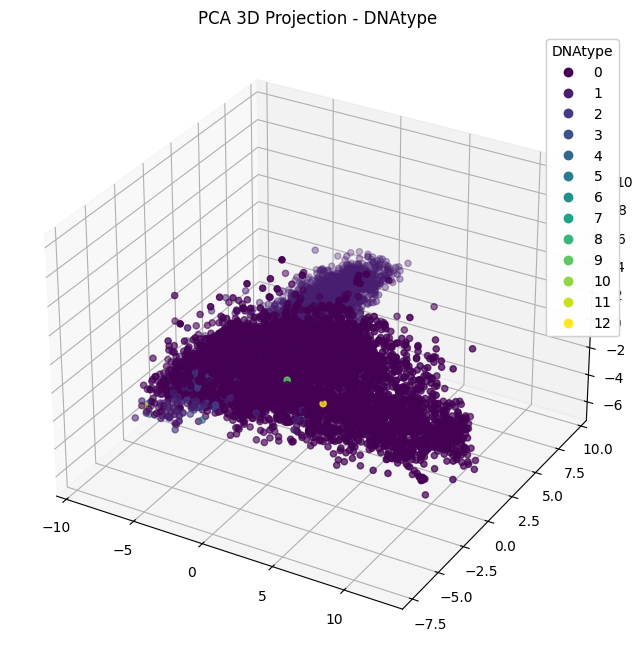

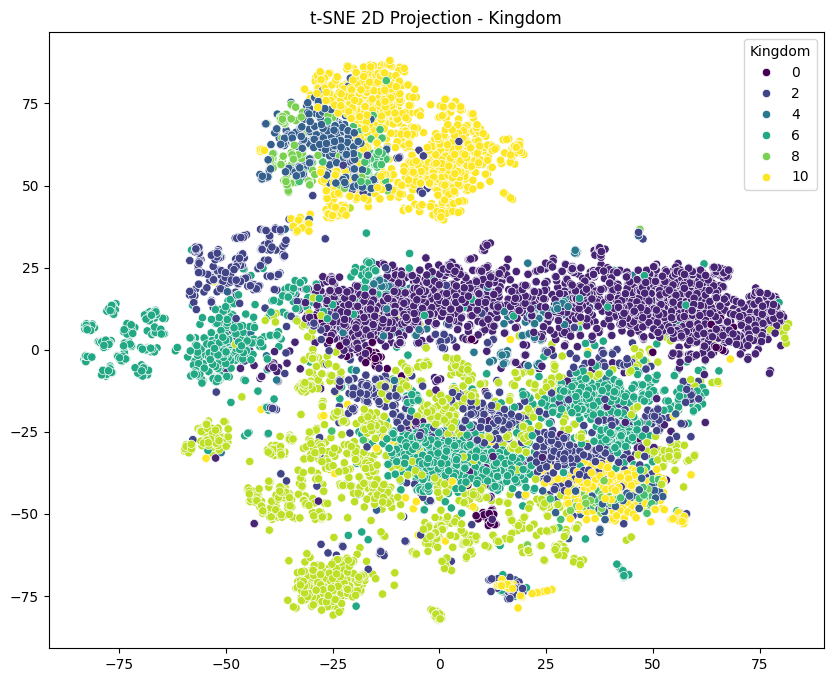

In [11]:
#PCA

#load datasets
train_data = pd.read_csv("train.csv")
train_data.drop(columns=train_data.columns[0], axis=1, inplace=True)

#visualize clusters
#separate features and target
X = train_data.drop(['Kingdom', 'DNAtype', 'SpeciesName'], axis=1).to_numpy()
label_encoder = LabelEncoder()
train_data['Kingdom'] = label_encoder.fit_transform(train_data['Kingdom'])
y_kingdom = train_data['Kingdom']
y_dnatype = train_data['DNAtype']

#standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# 3D Plot using PCA
#kingdom
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_kingdom, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Kingdom")
ax.add_artist(legend1)
plt.title('PCA 3D Projection - Kingdom')
plt.show()
#DNAtype
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_dnatype, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="DNAtype")
ax.add_artist(legend1)
plt.title('PCA 3D Projection - DNAtype')
plt.show()

# t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_kingdom, palette="viridis")
plt.title('t-SNE 2D Projection - Kingdom')
plt.show()

### 7. Clustering: applying clustering algorithm and evaluating their performance
- hierarchical clustering
- partitioning clustering: k-means and k-medoids
- density-based clustering: DBSCAN

Hierarchical clustering (linkage matrix and prediction)
Dendogram helps in visualizing hierarchical clustering and determining the number of clusters

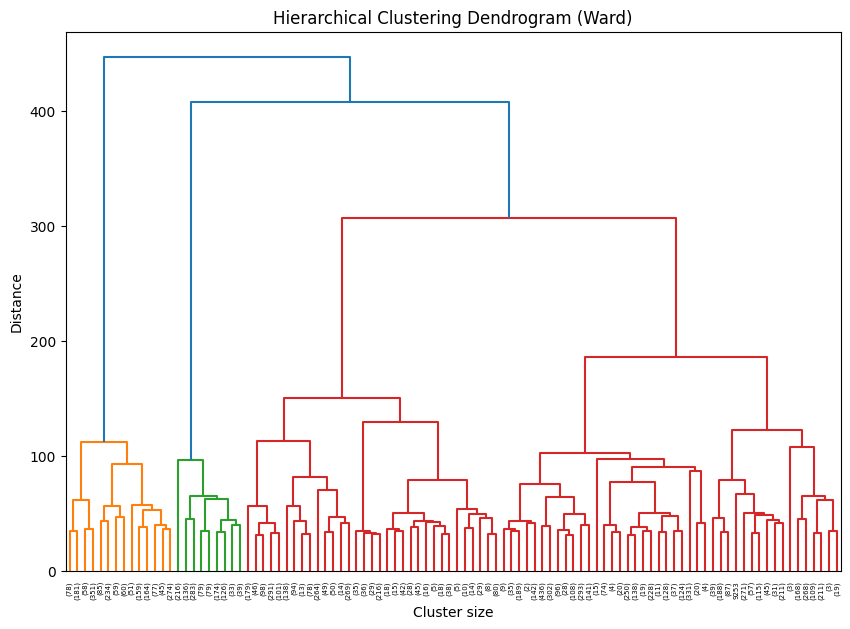

In [12]:
# Hierarchical Clustering using different linkage methods
Z_ward = linkage(X_scaled, method='ward')
Z_complete = linkage(X_scaled, method='complete')
Z_average = linkage(X_scaled, method='average')
Z_single = linkage(X_scaled, method='single')

# Plot dendrogram for the ward method
plt.figure(figsize=(10, 7))
dendrogram(Z_ward, truncate_mode='lastp', p=100)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

In [13]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])#matrix that contains zeros
    # Retrieve how many different cluster ids there are
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]

    for i in range(nclusters):
        sample_idx = np.where(y_pred == i)#position of true values, all inside same cluster, contains the indices of all points that belong to the current cluster i.
        # Compute all the possible combinations combinations of these indices
        idx = np.meshgrid(sample_idx, sample_idx)
        mat[idx[0], idx[1]] = 1

    return mat

def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()

    # Normalize distances in [0, 1] and compute the similarity
    sim_mat = 1 - (dist_mat-min_dist)/(max_dist-min_dist)
    return sim_mat

def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)


    inc = normalize(inc.reshape(1,-1))#Flattens the incidence matrix into a 1D array (row vector).
    sim = normalize(sim.reshape(1,-1))#Computes the dot product of the normalized incidence and similarity matrices. This gives a single scalar value (since both are now row vectors).
    corr = inc @ sim.T #[1, NF] * [NF, 1] --> [1,1]
    return corr[0,0]

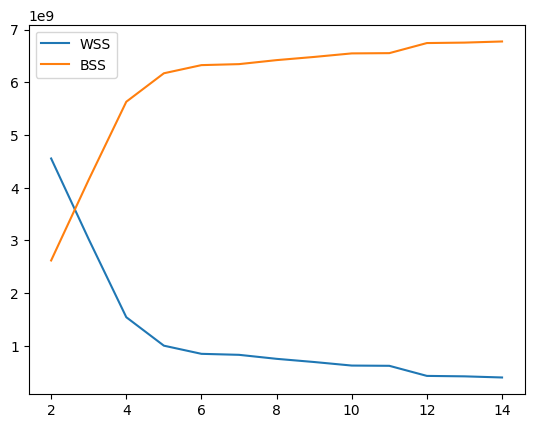

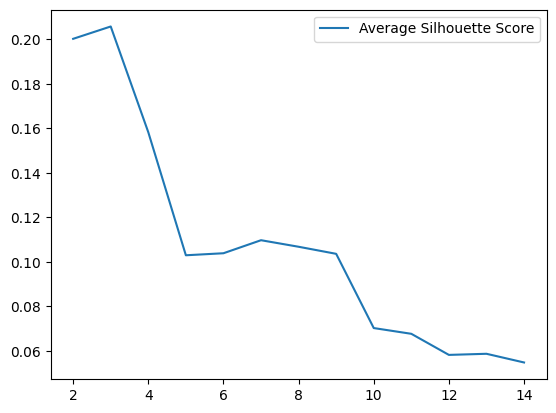

In [14]:
#Deciding the number of clusters
# Elbow method using WSS (Within-Cluster Sum of Squares) and BSS (Between-Cluster Sum of Squares)
def wss(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    dist_mat = pairwise_distances(X, metric=metric)
    dist_mat = dist_mat * inc
    triu_idx = np.triu_indices(X.shape[0], k=1)
    wss = (dist_mat[triu_idx]**2).sum()
    return wss

def bss(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    dist_mat = pairwise_distances(X, metric=metric)
    dist_mat = dist_mat * (1 - inc)
    triu_idx = np.triu_indices(X.shape[0], k=1)
    bss = (dist_mat[triu_idx]**2).sum()
    return bss
# Initialize lists to store WSS, BSS, and Silhouette scores
wss_list, bss_list, sil_list = [], [], []
clus_list = list(range(2, 15))

# Iterate over the list of cluster numbers
for nc in clus_list:
    model = AgglomerativeClustering(n_clusters=nc, linkage='ward')
    y_pred = model.fit_predict(X_scaled)
    # Compute WSS, BSS, and Silhouette Score for current number of clusters
    wss_list.append(wss(X_scaled, y_pred, 'euclidean'))
    bss_list.append(bss(X_scaled, y_pred, 'euclidean'))
    sil_list.append(silhouette_score(X_scaled, y_pred, metric='euclidean'))

# Plot WSS and BSS as a function of the number of clusters
plt.plot(clus_list, wss_list, label='WSS')
plt.plot(clus_list, bss_list, label='BSS')
plt.legend()
plt.show()
# Plot Silhouette Score as a function of the number of clusters
plt.plot(clus_list, sil_list, label='Average Silhouette Score')
plt.legend()
plt.show()


- BSS increases as the number of cluster increases, WSS decreases as the number of clustersincreases, as expected
- we cut where silhuettes has its maximum (between 3 and 4)

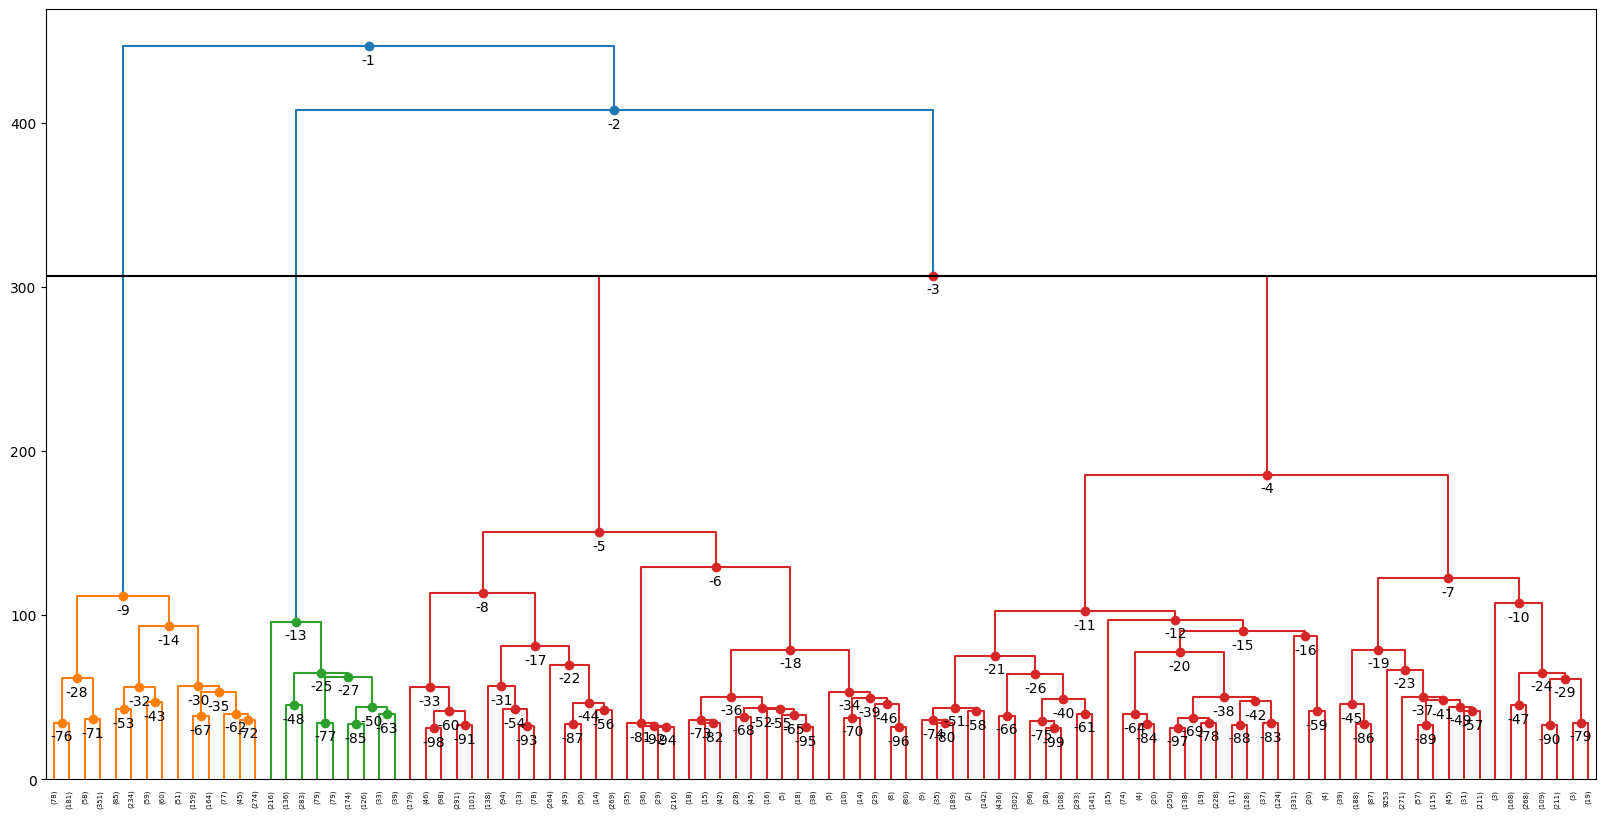

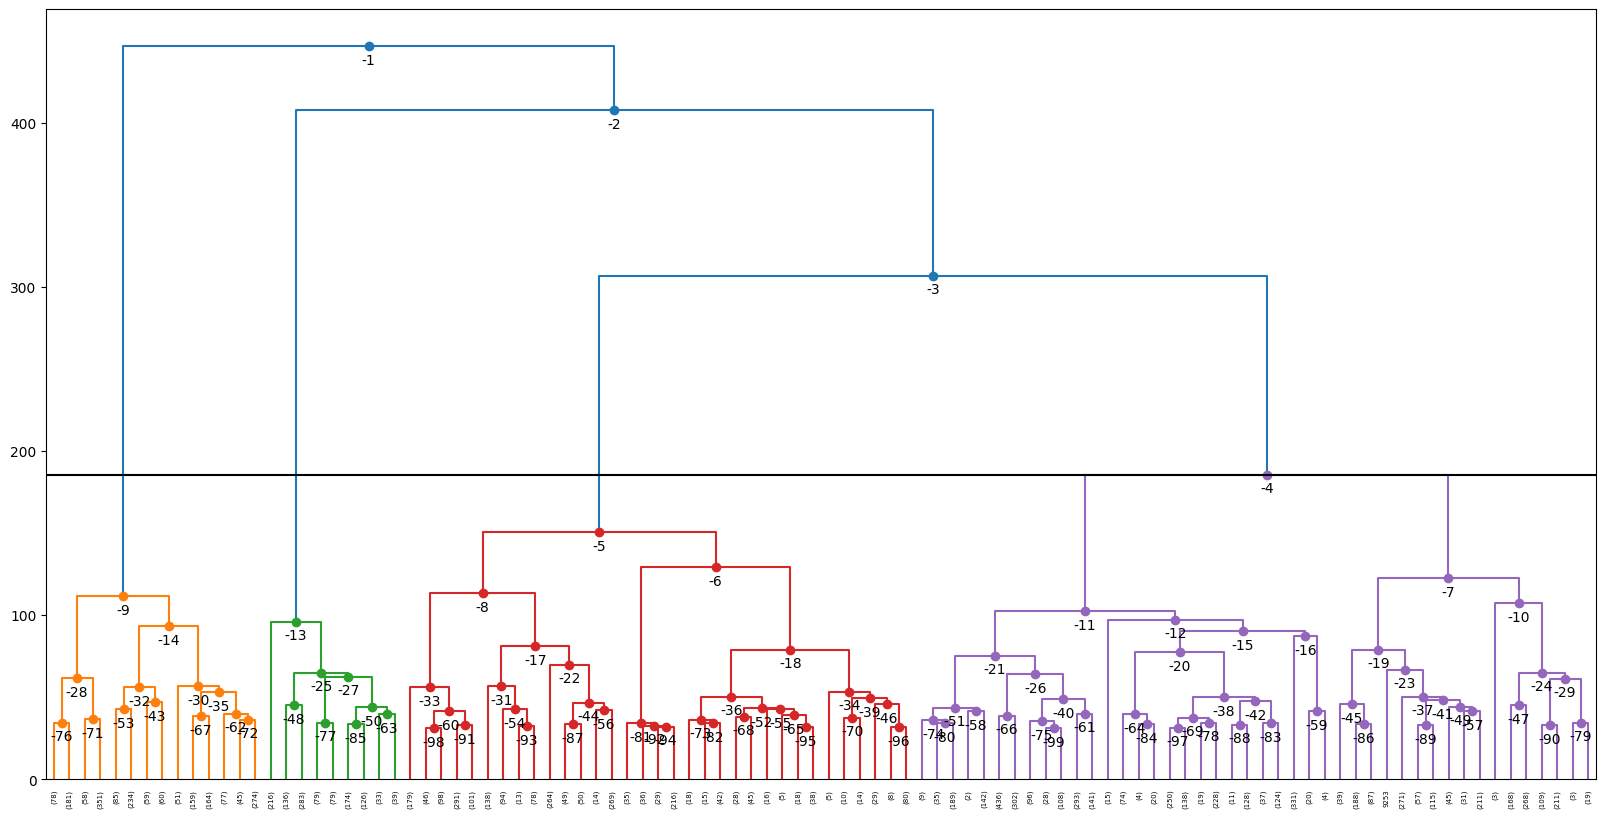

In [15]:
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # This block reconstructs the linkage matrix if a standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                 counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)

        # This block checks if 'n_clusters' keyword argument is provided
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-5 #select the height to cut, Z[-n_clusters, 2] retrieves the distance of the merge that results in exactly n_clusters clusters. This is because Z is sorted by merge order, so Z[-n_clusters] gives the n_clusters-th merge from the end (i.e., the merge that leaves exactly n_clusters clusters).
        #kwargs['color_threshold'] = None

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram, with keyword arguments
    ddata = dendrogram(Z,ax=ax, **kwargs)

    # This block annotates nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']): #x, y coordinates and color
        x = 0.5 * sum(i[1:3]) #position where to plot on x
        y = d[1]  #position where to plot on x
        nid = np.where(Z[:,2] == y)[0][0] #This is the third column of the linkage matrix Z, which contains the distances between clusters at each merge.

        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),# The text to be annotated. nid is the index of the merge, and Z.shape[0] is the number of merges. Subtracting these gives the node identifier.
                         textcoords='offset points',
                         va='top', ha='center')
    #This block draws a horizontal line at the color_threshold height to indicate the cut point for clusters.
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')

    return fig, ax

# Generate linkage matrix using Ward's method
Z = linkage(X_scaled, metric='euclidean', method='ward')
# Plot the dendrogram with specified parameters (3 and 4)
fig, ax = plot_dendrogram(Z=Z, X=X_scaled, truncate_mode='lastp',
                          p=100, n_clusters=3)
fig, ax = plot_dendrogram(Z=Z, X=X_scaled, truncate_mode='lastp',
                          p=100, n_clusters=4)

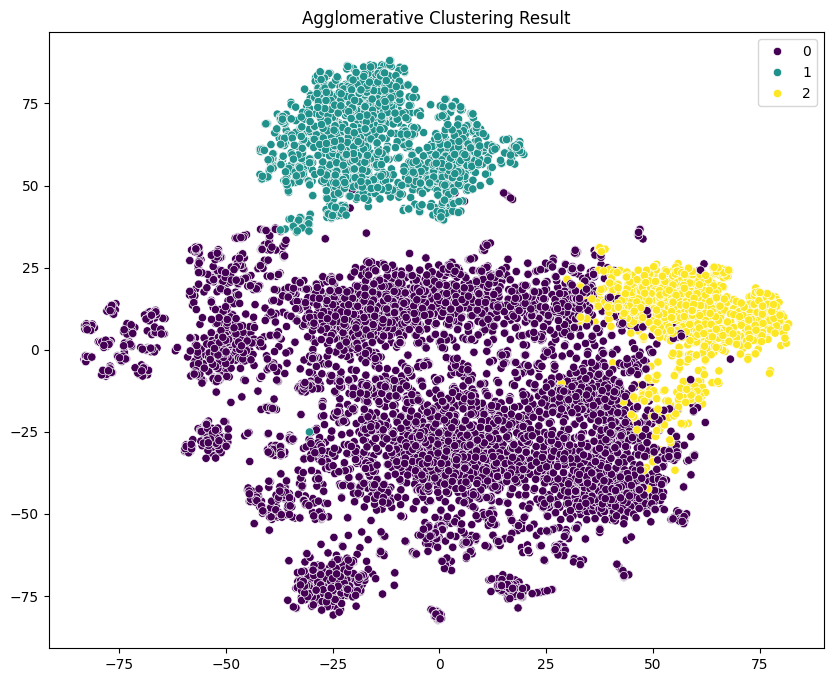

In [16]:
# Agglomerative Clustering with Ward Linkage
# Putting 3 as the number of clusters
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_pred = model.fit_predict(X_scaled)

# Visualization of the clustering result using t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_pred, palette="viridis")
plt.title('Agglomerative Clustering Result')
plt.show()

Check if the purity is better than the random purity

In [17]:
def get_Ncounts(y_predict, y_true, k, j=None):
    #N is the total number of samples
    N = X.shape[0]
    #Nk is the total number of samples in cluster k
    Nk_mask = y_predict==k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    #if we have a label
    if j is not None:
        Nj_mask = y_true==j
        Nj = Nj_mask.sum()
        #samples that are both in cluster k and with label j
        Nkj = np.logical_and(Nk_mask, Nj_mask).sum()
    return N, Nk, Nj, Nkj

##computing precision
def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)

#computing recall
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

#computing F1
def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

#computing purity
def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def total_purity(y_pred, y_true):
    N = y_true.shape[0]
    clusters = np.unique(y_pred)
    total_p = 0
    for k in clusters:
        _, Nk, _, _ = get_Ncounts(y_pred, y_true, k)
        pk = purity(y_pred, y_true, k)
        total_p += (Nk / N) * pk
    return total_p

print("Total Purity:", total_purity(y_pred, y_kingdom))
y_rand = np.random.randint(0,10, X.shape[0])
print("Total Purity Random:", total_purity(y_rand, y_kingdom))

Total Purity: 0.4273651890214969
Total Purity Random: 0.23143350604268279


K-means and K-medoids clustering

In [18]:
# KMeans Clustering
kmeans = KMeans(n_clusters=11, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

#K-medoids clustering, selecting initial medoids (you can randomly choose initial indices or use other strategies)
initial_medoids = np.random.choice(range(len(X_scaled)), 11, replace=False)

# Create kmedoids instance with chosen metric
metric = distance_metric(type_metric.EUCLIDEAN)
kmedoids_instance = kmedoids_clustering(X_scaled.tolist(), initial_medoids.tolist(), metric=metric)

# Run clustering
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()

# Convert cluster indices to label format for comparison
y_kmedoids = np.zeros(len(X_scaled))
for cluster_id, cluster in enumerate(clusters):
    for index in cluster:
        y_kmedoids[index] = cluster_id

# Evaluate and visualize KMeans
print("KMeans Purity:", total_purity(y_kmeans, y_kingdom))

# Evaluate and visualize KMedoids
print("KMedoids Purity:", total_purity(y_kmedoids, y_kingdom))

KMeans Purity: 0.5786797159788185
KMedoids Purity: 0.5702360391413689


K-means have the highest purity
- KMeans Purity: 0.5786797159788185
- KMedoids Purity: 0.5694684321562238

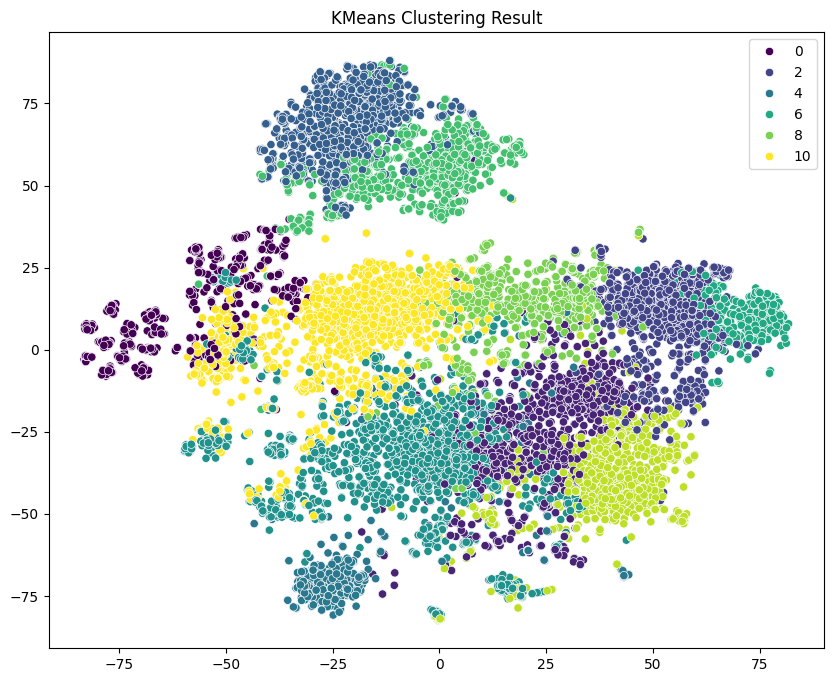

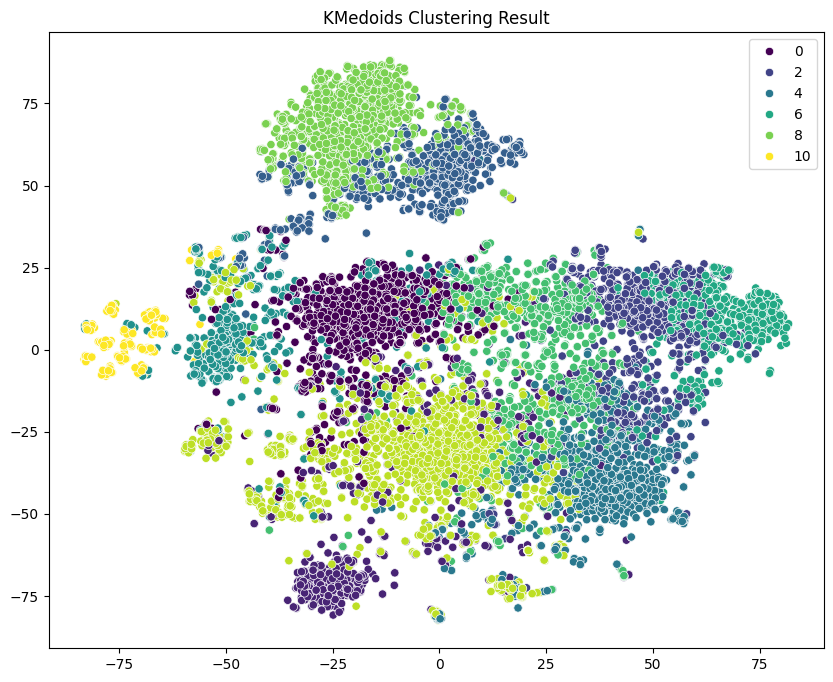

In [19]:
#Plotting KMeans and Kmedoids clustering results
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualization of KMeans using t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_kmeans, palette="viridis")
plt.title('KMeans Clustering Result')
plt.show()

# Visualization of KMedoids using t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_kmedoids, palette="viridis")
plt.title('KMedoids Clustering Result')
plt.show()


DBSCAN

Silhouette Score: 0.24


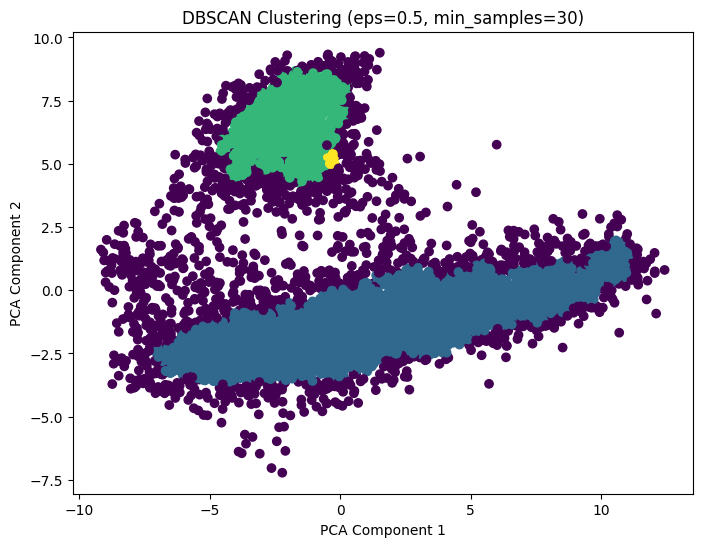

In [20]:
#load the dataset
train_data = pd.read_csv("train.csv")
train_data.drop(columns=train_data.columns[0], axis=1, inplace=True)

#separate features and target
X = train_data.drop(['Kingdom', 'DNAtype', 'SpeciesName'], axis=1).to_numpy()
label_encoder = LabelEncoder()
train_data['Kingdom'] = label_encoder.fit_transform(train_data['Kingdom'])

#standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DBSCAN
# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

# Apply DBSCAN with fixed parameters
dbscan = DBSCAN(eps=0.3, min_samples=20)
cluster_labels = dbscan.fit_predict(reduced_data)

# Calculate Silhouette Score
if len(set(cluster_labels)) > 1:
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.2f}")
else:
    print("Silhouette Score: Not applicable (only one cluster or all noise)")

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap="viridis")
plt.title(f"DBSCAN Clustering (eps=0.5, min_samples=30)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()



### 8. Clustering: algorithm performance comparison

KMeans
Algorithm: KMeans
Purity: 0.5786797159788185
Time taken: 0.15 seconds


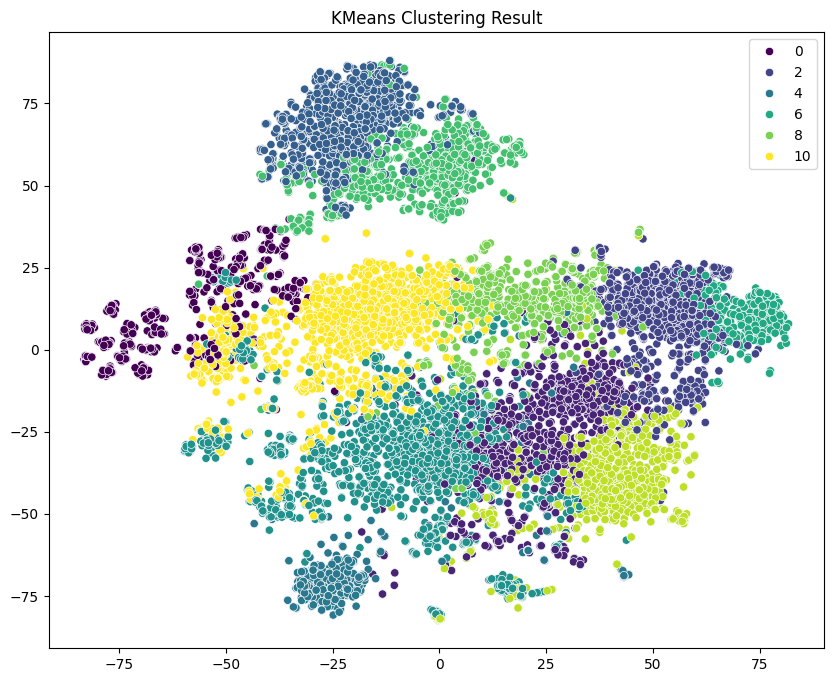

KMedoids
Algorithm: KMedoids
Purity: 0.5786797159788185


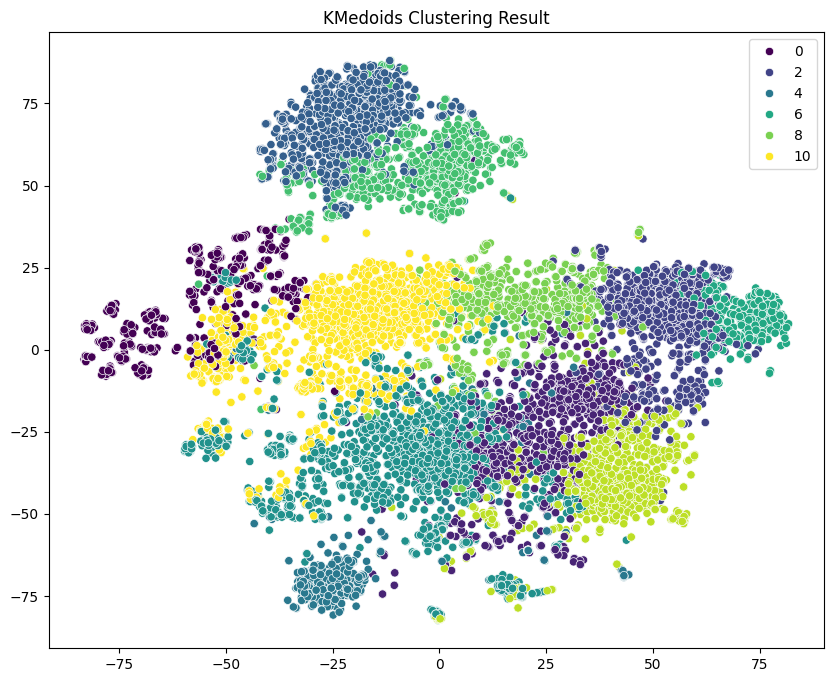

DBSCAN
Algorithm: DBSCAN
Purity: 0.22414123968506605
Time taken: 0.25 seconds


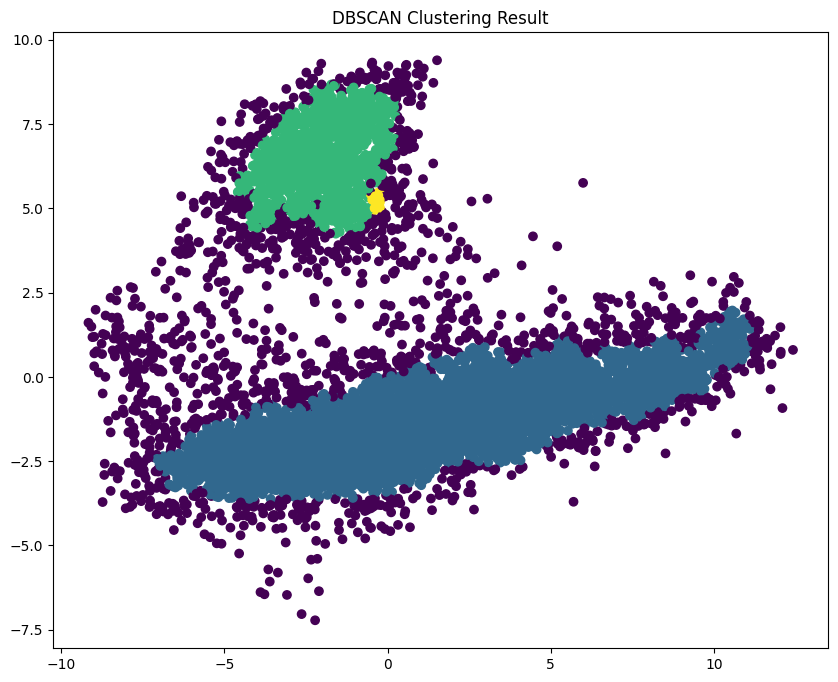

Agglomerative (ward)
Algorithm: Agglomerative (ward)
Purity: 0.6024755325207788
Time taken: 5.05 seconds


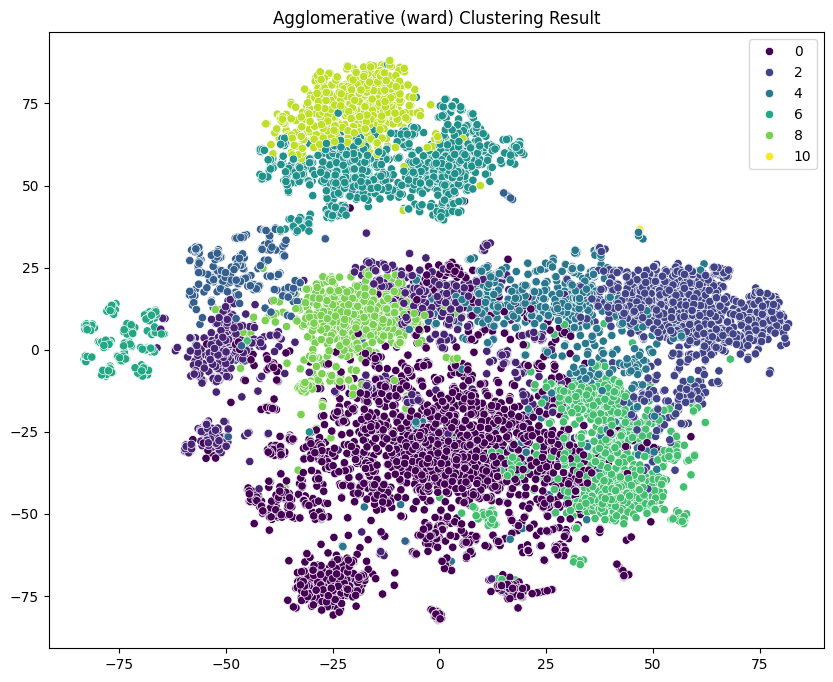

In [21]:
# Algorithm comparison
# List of clustering algorithms to compare
clustering_algorithms = [
    ('KMeans', KMeans(n_clusters=11, random_state=42)),
    ('KMedoids', kmedoids(X_scaled.tolist(), initial_medoids.tolist(), metric=metric, n_clusters=11, random_state=42)),
    ('DBSCAN', DBSCAN(eps=0.3, min_samples=20)),
    ('Agglomerative (ward)', AgglomerativeClustering(n_clusters=11, linkage='ward')),
]

# Iterate over algorithms and compare
for name, algorithm in clustering_algorithms:
    print(name)
    if(name=='KMedoids'):
        print(f"Algorithm: {name}")
        print(f"Purity: {total_purity(y_pred, y_kingdom)}")
    else:
        start_time = time.time()
        y_pred = algorithm.fit_predict(X_scaled)
        end_time = time.time()

        print(f"Algorithm: {name}")
        print(f"Purity: {total_purity(y_pred, y_kingdom)}")
        print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Visualization
    plt.figure(figsize=(10, 8))
    if name=='DBSCAN':
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap="viridis")
    else:
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_pred, palette="viridis")
    plt.title(f'{name} Clustering Result')
    plt.show()


Based on purity alone, Agglomerative clustering perform the best.
KMeans offers a good dbalance with an high purity score and a relaitvely fast time.

# 2. Perform classification to classify organisms into the 11 Kingdom classes.
Perform features selection, compare different algorithms and identify the
one that works the best on this dataset. Finally, test the performance of
the best algorithm on the provided test set.

### 1. Feature selection
Multiple least squares and linear regression

- Kingdom

In [22]:
#I have to transform the string column of kingdom to a numerical one
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the Kingdom column to numeric values
train_data['Kingdom_numeric'] = label_encoder.fit_transform(train_data['Kingdom'])

# Create a legend (dictionary) that maps original Kingdom labels to their numeric values
kingdom_legend = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Display the legend
print("Kingdom Legend:", kingdom_legend)

# adjust features and target variables
# Define the features (codon frequencies) and the target (DNAtype or Kingdom)
X = train_data.drop(['Kingdom', 'DNAtype', 'SpeciesName'], axis=1).to_numpy()
y_kingdom = train_data['Kingdom_numeric'].to_numpy()


Kingdom Legend: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10)}


In [25]:
#apply the Multiple Least Squares function
def multiple_least_squares(X, y):
    # Reshape X to be a 2D array if it's 1D
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    betas = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T).dot(y)
    # Returns the predictions for convenience
    pred = X.dot(betas).reshape(-1)
    return betas, pred

# Computes coefficient statistcs
def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features

    # If the ones column has not been added
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)

    # Compute the prediction
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE2 = ((y-pred)**2).sum()/(deg)

    # Compute the t statistics assuming the optimal parameter is zero
    se2_b = RSE2*(np.linalg.inv(np.dot(X.T, X)).diagonal())
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b

    # Compute the p-value
    p_values = [2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b]

    # Print values
    se_b = np.round(se_b,4)
    t_stat_b = np.round(t_stat_b,2)
    p_values = np.round(p_values,4)
    betas = np.round(betas,3)

    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0

    print(df)
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]
    print("RSS: {}".format(RSS))
    print("MSE: {}".format(MSE))

# Perform linear regression using multiple least squares
betas, y_pred = multiple_least_squares(X, y_kingdom)

# Show statistics for the coefficients
feature_names = ['Intercept'] + list(train_data.drop(['Kingdom', 'DNAtype', 'SpeciesName'], axis=1).columns)

show_stats(X, y_kingdom, betas, feature_names, alpha=0.05)


               Name  Coefficients  Standard Errors        t-stat  p-value  \
0         Intercept          -0.0           0.0002 -0.000000e+00   0.9979   
1         SpeciesID           0.0           0.0000  4.720000e+00   0.0000   
2           Ncodons           0.0           0.0000  5.000000e-02   0.9577   
3               UUU          -0.0           0.0002 -9.000000e-02   0.9253   
4               UUC           0.0           0.0002  0.000000e+00   0.9996   
..              ...           ...              ...           ...      ...   
63              GAG          -0.0           0.0002 -0.000000e+00   0.9992   
64              UAA           0.0           0.0002  0.000000e+00   0.9993   
65              UAG          -0.0           0.0002 -0.000000e+00   0.9988   
66              UGA          -0.0           0.0002 -0.000000e+00   0.9988   
67  Kingdom_numeric           1.0           0.0000  2.572652e+08   0.0000   

    reject H0  
0       False  
1        True  
2       False  
3       Fal

In [26]:
#perform feature-wise regression
for feature in train_data.drop(['Kingdom', 'DNAtype', 'SpeciesName'], axis=1).columns:
    X = train_data[[feature]].to_numpy()
    betas, _ = multiple_least_squares(X, y_kingdom)
    print(f"\n Linear Regression using {feature}")
    show_stats(X, y_kingdom, betas, ['Intercept', feature], alpha=0.05)



 Linear Regression using SpeciesID
        Name  Coefficients  Standard Errors  t-stat  p-value  reject H0
0  Intercept         5.368             0.05   107.4      0.0       True
1  SpeciesID         0.000             0.00     5.8      0.0       True
RSS: 129625.22031531879
MSE: 12.437653071897792

 Linear Regression using Ncodons
        Name  Coefficients  Standard Errors  t-stat  p-value  reject H0
0  Intercept         5.618           0.0347  161.81      0.0       True
1    Ncodons        -0.000           0.0000   -9.39      0.0       True
RSS: 128953.73084077908
MSE: 12.373223070502695

 Linear Regression using UUU
        Name  Coefficients  Standard Errors  t-stat  p-value  reject H0
0  Intercept         5.780           0.0564  102.41      0.0       True
1        UUU       -11.906           2.6227   -4.54      0.0       True
RSS: 129787.58637189826
MSE: 12.453232236796993

 Linear Regression using UUC
        Name  Coefficients  Standard Errors  t-stat  p-value  reject H0
0  Int

Results of performing simple linear regression against the target variable Kingdom.
- looking at the p-value, the significant features are all except for AUU, GCU, ACC, AAC, CAU, UAA, UAG


In [27]:
#perform hypothesis tests
from scipy.stats import f

def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def tss(y):
    return np.sum((y - y.mean()) ** 2)

# Train the complete model
X_complete = train_data.drop(['Kingdom', 'DNAtype', 'SpeciesName'], axis=1).to_numpy()
betas_complete, y_pred = multiple_least_squares(X_complete, y_kingdom)

n = X_complete.shape[0]
nf_complete = X_complete.shape[1]

rss_complete = rss(y_kingdom, y_pred)
tss_y=tss(y_kingdom)

#compute f-statistics
F_num = (tss_y - rss_complete)/nf_complete
F_den = rss_complete/(n-nf_complete-1)
F = F_num/F_den

#compute the p-value
alpha = 0.005
p_value=f.sf(F, nf_complete, n-nf_complete-1)

print("F-stat: ", F)
print("p-value: ", p_value)
if p_value < alpha:
    print("Reject H0: At least one coefficient is different from 0")
else:
    print("Accept H0: No evidence to say that at least one coefficient is different from 0")

F-stat:  2379650807136131.5
p-value:  0.0
Reject H0: At least one coefficient is different from 0


In [28]:
X = sm.add_constant(X)  # Add a constant term for the intercept
model = sm.OLS(y_kingdom, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.110e+32
Date:                Sun, 01 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:23:50   Log-Likelihood:             3.1518e+05
No. Observations:               10422   AIC:                        -6.303e+05
Df Residuals:                   10420   BIC:                        -6.303e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.993e-14   3.26e-16    -91.885      0.0

I will perform more feature selection later, since this one doesn't perform well with this dataset

### 2. Classification

Data preparation

In [29]:
# Load train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Drop irrelevant columns and the 'AGA' codon (which is missing in the test set)
X_train = train.drop(columns=['Unnamed: 0', 'Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'AGA'])
y_train = train['Kingdom'].astype('category').cat.codes  # Convert Kingdom to numerical labels

X_test = test.drop(columns=['Unnamed: 0', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'Kingdom'])
y_test = test['Kingdom'].astype('category').cat.codes

# Standardize features (to have mean 0, variance 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Classification algorithms

Support Vector Machines (SVM)

In [30]:
#SVM

#linear svm (hard margins)
# Linearly separable case (hard margins)
model_linear = SVC(kernel='linear', C=100)
model_linear.fit(X_train_scaled, y_train)

# Evaluate accuracy on training set
train_acc_linear = accuracy_score(y_train, model_linear.predict(X_train_scaled))
print("Linear SVM Train Accuracy (Hard Margins):", train_acc_linear)

# Linearly separable case, soft margin
model_soft = SVC(kernel='linear', C=1)
model_soft.fit(X_train_scaled, y_train)

# Evaluate accuracy on training set
train_acc_soft = accuracy_score(y_train, model_soft.predict(X_train_scaled))
print("Linear SVM Train Accuracy (Soft Margins):", train_acc_soft)

Linear SVM Train Accuracy (Hard Margins): 0.8950297447706774
Linear SVM Train Accuracy (Soft Margins): 0.8882172327768183


In [31]:
#train vs test train accuracy
# Predict the labels for the training and test datasets
y_train_pred_hardSVD = model_linear.predict(X_train_scaled)
y_test_pred_hardSVD = model_linear.predict(X_test_scaled)

# Compute accuracy on the training dataset
train_accuracy_SVDH = accuracy_score(y_train, y_train_pred_hardSVD)
print("SVM Train Accuracy (hard margins):", train_accuracy_SVDH)

# Compute accuracy on the test dataset
test_accuracy_SVDH = accuracy_score(y_test, y_test_pred_hardSVD)
print("SVM Test Accuracy (hard margins):", test_accuracy_SVDH)
#---

# Predict the labels for the training and test datasets
y_train_pred_softSVD = model_soft.predict(X_train_scaled)
y_test_pred_softSVD = model_soft.predict(X_test_scaled)

# Compute accuracy on the training dataset
train_accuracy_SVDS = accuracy_score(y_train, y_train_pred_softSVD)
print("SVM Train Accuracy (soft margins):", train_accuracy_SVDS)

# Compute accuracy on the test dataset
test_accuracy_SVDS = accuracy_score(y_test, y_test_pred_softSVD)
print("SVM Test Accuracy (soft margins):", test_accuracy_SVDS)


SVM Train Accuracy (hard margins): 0.8950297447706774
SVM Test Accuracy (hard margins): 0.8587874136607828
SVM Train Accuracy (soft margins): 0.8882172327768183
SVM Test Accuracy (soft margins): 0.8587874136607828


This indicates how well the model performs on the training data: the high margins SVM achieved slightly higher accuracy.

In [32]:
#Classification metrics

# Predict on the training data
y_train_pred_linear = model_linear.predict(X_train_scaled)
y_train_pred_soft = model_soft.predict(X_train_scaled)

# Print classification reports
print("Classification Report (Linear SVM - Hard Margins):")
print(classification_report(y_train, y_train_pred_linear))

print("Classification Report (Linear SVM - Soft Margins):")
print(classification_report(y_train, y_train_pred_soft))



Classification Report (Linear SVM - Hard Margins):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       101
           1       0.93      0.96      0.94      2336
           2       0.79      0.72      0.75      1076
           3       0.86      0.88      0.87       458
           4       0.86      0.72      0.78       176
           5       1.00      0.21      0.35        14
           6       0.87      0.86      0.87      2018
           7       0.87      0.77      0.82       144
           8       0.83      0.66      0.74       172
           9       0.91      0.93      0.92      2265
          10       0.94      0.96      0.95      1662

    accuracy                           0.90     10422
   macro avg       0.88      0.79      0.81     10422
weighted avg       0.89      0.90      0.89     10422

Classification Report (Linear SVM - Soft Margins):
              precision    recall  f1-score   support

           0       0.81      0

/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Hard margin SVM has 90% accuracy (high accuracy) and good precision. The f1 score indicates a solid balance between precision and recall.
Soft marigin SVM has slightly lower accuracy compared to hard margin SVM, and performs marginaly worse in terms of f1 score.

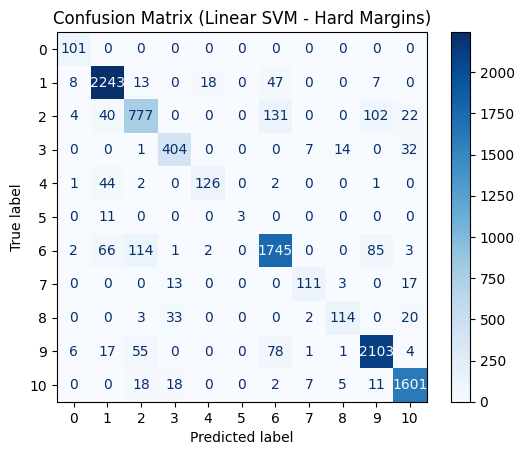

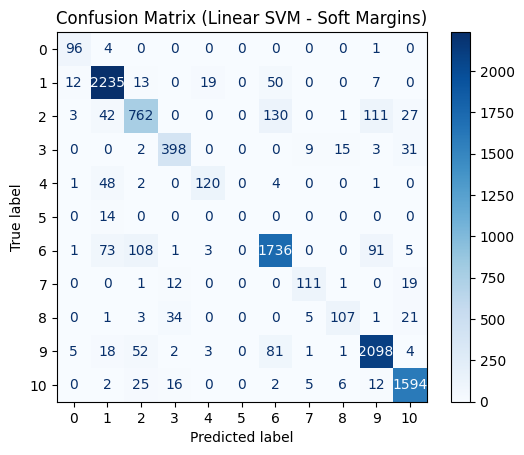

In [33]:
#confusion matrix
# Evaluate on training set
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Confusion matrix for linear SVM (hard margins)
cm_linear = confusion_matrix(y_train, model_linear.predict(X_train_scaled))
disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=model_linear.classes_)
disp_linear.plot(cmap='Blues')
plt.title("Confusion Matrix (Linear SVM - Hard Margins)")
plt.show()

# Confusion matrix for linear SVM (soft margins)
cm_soft = confusion_matrix(y_train, model_soft.predict(X_train_scaled))
disp_soft = ConfusionMatrixDisplay(confusion_matrix=cm_soft, display_labels=model_soft.classes_)
disp_soft.plot(cmap='Blues')
plt.title("Confusion Matrix (Linear SVM - Soft Margins)")
plt.show()


The x axis represents the predicted labels, the y axis the true labels. Each cell shows the number of instances where the true label was i but the model predicted it as j.
The cells along the diagonal represent the instances where the model predictions were correct.

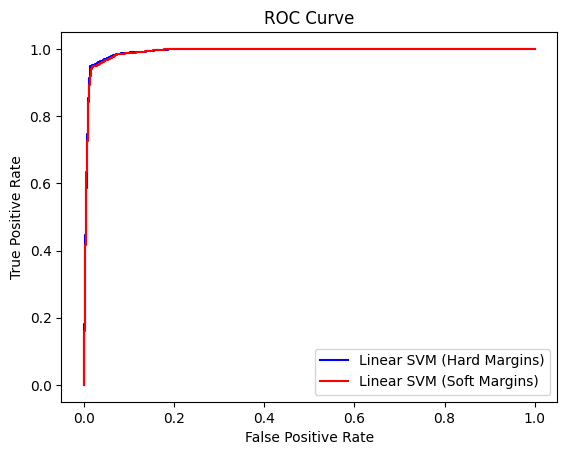

In [34]:
#ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC for both models
y_score_linear = model_linear.decision_function(X_train_scaled)
fpr_linear, tpr_linear, _ = roc_curve(y_train, y_score_linear[:,1], pos_label=1)

y_score_soft = model_soft.decision_function(X_train_scaled)
fpr_soft, tpr_soft, _ = roc_curve(y_train, y_score_soft[:,1], pos_label=1)

# Plot ROC curve
plt.plot(fpr_linear, tpr_linear, color='blue', label='Linear SVM (Hard Margins)')
plt.plot(fpr_soft, tpr_soft, color='red', label='Linear SVM (Soft Margins)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Logistic Regression

In [35]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

pd.isna(test_data).any()
#no missing values

# Drop irrelevant columns (assuming 'SpeciesID', 'Ncodons', 'SpeciesName' are not features for classification)
X = train_data.drop(columns=['Unnamed: 0', 'Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'AGA'])
y = train_data['Kingdom']

# Convert categorical target (Kingdom) to numerical labels
y = y.astype('category').cat.codes
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [36]:
#classification with linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_class = np.round(y_pred).astype(int)  # Round and convert to int for classification

print("Train accuracy:", accuracy_score(y_train, np.round(model.predict(X_train)).astype(int)))
print("Test accuracy:", accuracy_score(y_test, y_pred_class))


Train accuracy: 0.17368357922514094
Test accuracy: 0.18609112709832135


The model's performance is quite low

In [37]:
#thresholding on predicted probability
def hard_threshold(y_pred, threshold=0.5):
    return (y_pred > threshold).astype(int)

# Apply thresholding
y_pred_thresholded = hard_threshold(y_pred, 0.5)

# Evaluate accuracy with thresholding
print("Test accuracy with thresholding:", accuracy_score(y_test, y_pred_thresholded))

Test accuracy with thresholding: 0.19376498800959233


In [38]:
# Logistic Regression using all features
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))


Train accuracy: 0.8575026988125225
Test accuracy: 0.837410071942446


/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Text(0, 0.5, 'beta')

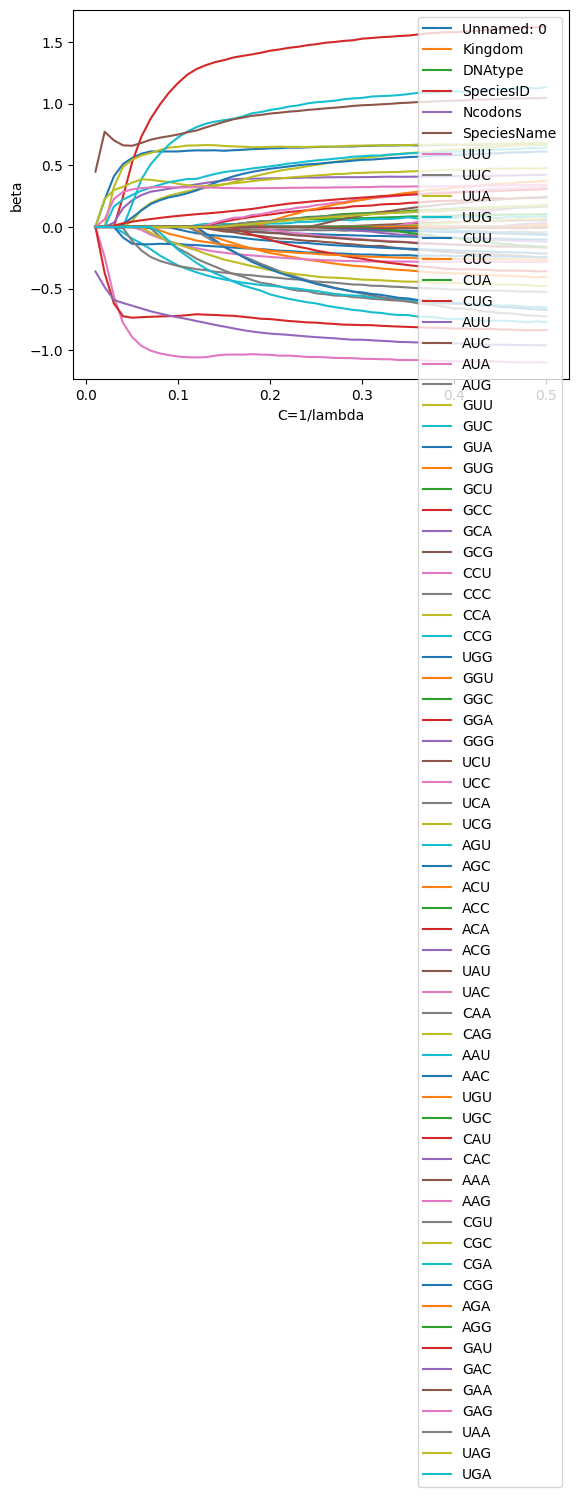

In [39]:
C_vals = np.linspace(1e-2, 0.5, 50)
betas = []

from sklearn import preprocessing
X_std = preprocessing.scale(X_train)

for C in C_vals:
   model = LogisticRegression(solver='saga', penalty='l1', C=C)
   model.fit(X_std, y_train)
   beta = model.coef_.reshape(-1) # colecting betas
   betas.append(beta)
betas = np.stack(betas, axis=1)
for beta, name in zip(betas, list(train_data.columns)):
    plt.plot(C_vals, beta, label=name)
plt.legend()
plt.xlabel("C=1/lambda")
plt.ylabel("beta")

In [40]:
# Load dataset
train = pd.read_csv('train.csv')

# Drop irrelevant columns and the 'AGA' codon
X = train.drop(columns=['Unnamed: 0', 'Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'AGA'])
y = train['Kingdom']

# Convert categorical target (Kingdom) to numerical labels
y = y.astype('category').cat.codes

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature selection with Lasso

Selected features: Index(['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUA', 'AUU', 'AUC', 'AUA', 'AUG',
       'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU', 'CCC',
       'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC', 'UCA',
       'UCG', 'AGU', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC', 'CAA', 'CAG',
       'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG', 'CGU', 'CGC',
       'CGA', 'CGG', 'AGG', 'GAU', 'GAA', 'GAG', 'UAA', 'UAG', 'UGA'],
      dtype='object')
Number of selected features: 59


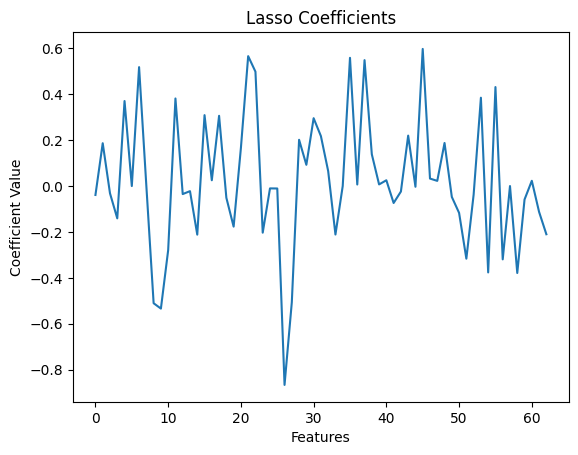

In [41]:
#feature selection with Lasso
from sklearn.linear_model import Lasso

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Lasso for feature selection
lasso = Lasso(alpha=0.01)  # Adjust alpha for regularization strength
lasso.fit(X_train_scaled, y_train)

# Identify selected features
selected_features = X.columns[lasso.coef_ != 0]
print("Selected features:", selected_features)
print(f"Number of selected features: {len(selected_features)}")

# Plot coefficients
plt.plot(lasso.coef_)
plt.title('Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

# Use only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Logistic regression with lasso feature selection

In [42]:
#classification models and evaluation
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_selected, y_train)

# Evaluate
log_reg_train_accuracy = accuracy_score(y_train, log_reg.predict(X_train_selected))
log_reg_test_accuracy = accuracy_score(y_test, log_reg.predict(X_test_selected))

print("Logistic Regression Train Accuracy:", log_reg_train_accuracy)
print("Logistic Regression Test Accuracy:", log_reg_test_accuracy)


Logistic Regression Train Accuracy: 0.6306824997001319
Logistic Regression Test Accuracy: 0.6316546762589929


LDA (Linear Discriminant Analysis) with lasso feature selection

In [43]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_selected, y_train)

# Evaluate
lda_train_accuracy = accuracy_score(y_train, lda.predict(X_train_selected))
lda_test_accuracy = accuracy_score(y_test, lda.predict(X_test_selected))

print("LDA Train Accuracy:", lda_train_accuracy)
print("LDA Test Accuracy:", lda_test_accuracy)


LDA Train Accuracy: 0.7856543121026748
LDA Test Accuracy: 0.7875299760191846


QDA with lasso feature selection

In [44]:
#QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# QDA model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_selected, y_train)

# Evaluate
qda_train_accuracy = accuracy_score(y_train, qda.predict(X_train_selected))
qda_test_accuracy = accuracy_score(y_test, qda.predict(X_test_selected))

print("QDA Train Accuracy:", qda_train_accuracy)
print("QDA Test Accuracy:", qda_test_accuracy)


QDA Train Accuracy: 0.8720163128223581
QDA Test Accuracy: 0.818705035971223


/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KNN

In [45]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

# KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Use k=5 as a starting point
knn.fit(X_train_selected, y_train)

# Evaluate
knn_train_accuracy = accuracy_score(y_train, knn.predict(X_train_selected))
knn_test_accuracy = accuracy_score(y_test, knn.predict(X_test_selected))

print("KNN Train Accuracy:", knn_train_accuracy)
print("KNN Test Accuracy:", knn_test_accuracy)


KNN Train Accuracy: 0.8969653352524889
KNN Test Accuracy: 0.8350119904076738


### Classification: model comparison

In [46]:
#model comparison
# Collect all results in a dictionary
results = {
    'Logistic Regression': {'train_accuracy': log_reg_train_accuracy, 'test_accuracy': log_reg_test_accuracy},
    'SVM Hard margins': {'train_accuracy': train_accuracy_SVDH, 'test_accuracy': test_accuracy_SVDH},
    'SVM Soft margins': {'train_accuracy': train_accuracy_SVDS, 'test_accuracy': test_accuracy_SVDS},
    'LDA': {'train_accuracy': lda_train_accuracy, 'test_accuracy': lda_test_accuracy},
    'QDA': {'train_accuracy': qda_train_accuracy, 'test_accuracy': qda_test_accuracy},
    'KNN': {'train_accuracy': knn_train_accuracy, 'test_accuracy': knn_test_accuracy},
}

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}: Train Accuracy = {metrics['train_accuracy']:.4f}, Test Accuracy = {metrics['test_accuracy']:.4f}")

# Determine the best model based on test accuracy
best_model = max(results, key=lambda x: results[x]['test_accuracy'])
print(f"Best model: {best_model}")


Logistic Regression: Train Accuracy = 0.6307, Test Accuracy = 0.6317
SVM Hard margins: Train Accuracy = 0.8950, Test Accuracy = 0.8588
SVM Soft margins: Train Accuracy = 0.8882, Test Accuracy = 0.8588
LDA: Train Accuracy = 0.7857, Test Accuracy = 0.7875
QDA: Train Accuracy = 0.8720, Test Accuracy = 0.8187
KNN: Train Accuracy = 0.8970, Test Accuracy = 0.8350
Best model: SVM Hard margins


# 3. Regression
We want to recover from the data loss of the AGA frequency on test
samples. Train a regressor which can predict the value of the AGA feature
given the remaining ones. Compare different regression algorithms for this
task. Since AGA features are missing in test samples, use only the training
data for this step and make use of robust evaluation techniques to compare
algorithms.

Data preparation

In [47]:
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

# Remove the first column
test_data.drop(columns=test_data.columns[0], axis=1, inplace=True)
train_data.drop(columns=train_data.columns[0], axis=1, inplace=True)
train_data.drop(['SpeciesName'], axis=1, inplace=True)
test_data.drop(['SpeciesName'], axis=1, inplace=True)


In [48]:
label_encoder = LabelEncoder()
train_data['Kingdom'] = label_encoder.fit_transform(train_data['Kingdom'])
np.unique(train_data['Kingdom'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [49]:
train_data = train_data.astype(np.float32)
#all features except for Kindom
X_all_features = train_data.columns.tolist()
X_all_features.remove('Kingdom')
# Select the features and convert them to numpy
X = train_data[X_all_features].to_numpy()
# y just the 'Kingdom' column
y = train_data['Kingdom'].to_numpy()

print("X.shape", X.shape, "X.dtype", X.dtype)
print("y.shape", y.shape, "y.dtype", y.dtype)

#split the data
test_size = 0.3
test_seed = 40
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

X.shape (10422, 67) X.dtype float32
y.shape (10422,) y.dtype float32
X_train.shape  (7295, 67)
X_test.shape  (3127, 67)


### Linear Regression

In [50]:
#Linear regression
from sklearn.metrics import r2_score, mean_squared_error

model = LinearRegression(fit_intercept=True) # 1- hyperparams selection
model = model.fit(X_train, y_train)          # 2- model fitting
y_predict_test = model.predict(X_test)       # 3- prediction
y_predict_train = model.predict(X_train)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.03665965795516968
Train MSE score  12.054607
Test R2 score  0.043733954429626465
Test MSE score  11.841949


In [51]:
for idx, col_name in enumerate(X_all_features):
    print("The coefficient for {} is {}".format(col_name, model.coef_[idx]))
print("The intercept is {:0.3f}".format(model.intercept_))

The coefficient for DNAtype is 0.7835822701454163
The coefficient for SpeciesID is 1.847493422246771e-06
The coefficient for Ncodons is -4.528365025180392e-07
The coefficient for UUU is -0.0006978139281272888
The coefficient for UUC is 0.0024185110814869404
The coefficient for UUA is 0.01040157862007618
The coefficient for UUG is -0.00025230817846022546
The coefficient for CUU is 0.004354247823357582
The coefficient for CUC is -0.000461478135548532
The coefficient for CUA is 0.012088210321962833
The coefficient for CUG is -0.0055872490629553795
The coefficient for AUU is 0.008837557397782803
The coefficient for AUC is 0.002208154648542404
The coefficient for AUA is 0.007903631776571274
The coefficient for AUG is -0.003219377947971225
The coefficient for GUU is -0.00012599978072103113
The coefficient for GUC is -0.0035220570862293243
The coefficient for GUA is 0.0035400716587901115
The coefficient for GUG is -0.0056131258606910706
The coefficient for GCU is -0.0006514493725262582
The co

In [52]:
from scipy.stats import t, f
tmp = []

def rss(y_true, y_pred): #implementation from the last lab session (already exist in SKLearn)
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def tss(y):
    return np.sum((y - y.mean()) ** 2)

def multiple_least_squares(X, y): #function to train the model using least, last time you implemented by scratch
    # Helper function that uses scikit-learn models
    # and behaves as the function we implemented in
    # Lab02.01
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred


# Computes coefficient statistcs
#this function is doing t test for each feature, and we check to see if there is any statistical evidence that each feature is correlated to the outcome (rejectH0)
def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features

    # If the ones column has not been added
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)

    # Compute the prediction
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE = ((y-pred)**2).sum()/(n_samples - n_features)

    # Compute the t statistics
    se2_b = RSE*(np.linalg.inv(np.dot(X.T, X)).diagonal())
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b

    # Compute the p-value
    p_values = np.array([2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b])

    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0
    tmp = rejectH0.copy()
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]
    #print("RSS: {}".format(RSS))

    return df, tmp

# H0: all features in the subset are equal to 0
#F test, within subset of features at least one is relevant (H0=all features are zero if we accept it none of the feature is usefuk)
def Ftest_restricted(data, y, subset_features):
    # Train the complete model
    X_complete = data.to_numpy()
    y = y.to_numpy()
    n = X_complete.shape[0]

    betas_complete, y_pred = multiple_least_squares(X_complete, y)
    rss_complete = rss(y, y_pred)
    nf_complete = X_complete.shape[1]

    # Train the restricted model
    notS = data.columns.difference(subset_features)
    X_restr = data[notS].to_numpy()
    betas_restr, y_pred = multiple_least_squares(X_restr, y)

    rss_restr = rss(y, y_pred)
    nf_restr = X_restr.shape[1]

    q = nf_complete - nf_restr

    # Compute F statistics
    F_num = (rss_restr - rss_complete) / q
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den
    #we got the same but alpha value doesn't chnage as we add some more features
    # Compute the p-value
    p_value = f.sf(F, q, n - nf_complete - 1)
    return p_value, F



In [53]:
betas = np.array([model.intercept_, *model.coef_]).reshape(-1, 1) #single array of all parameters in the model (number of betas and one as a feature)
ss, tmp = show_stats(X_train, y_train, betas, ['Intercept', *X_all_features], alpha=0.001) #increasing number of features probability of making an error is increasing, with 100 features, we have 100% of probability of making at least one error
print(ss)

         Name  Coefficients  Standard Errors        t-stat       p-value  \
0   Intercept  5.115208e+00     9.984473e+02  5.123163e-03  9.959125e-01   
1     DNAtype  7.835823e-01     8.799118e-02  8.905237e+00  6.647212e-19   
2   SpeciesID  1.847493e-06     3.417524e-07  5.405941e+00  6.652875e-08   
3     Ncodons -4.528365e-07     6.220013e-08 -7.280314e+00  3.681881e-13   
4         UUU -6.978139e-04     9.983886e+02 -6.989402e-07  9.999994e-01   
..        ...           ...              ...           ...           ...   
63        GAA -1.559209e-03     9.985476e+02 -1.561477e-06  9.999988e-01   
64        GAG -8.158039e-03     9.984347e+02 -8.170829e-06  9.999935e-01   
65        UAA -8.606776e-04     9.984107e+02 -8.620477e-07  9.999993e-01   
66        UAG -1.918297e-05     9.987493e+02 -1.920699e-08  1.000000e+00   
67        UGA  5.136702e-03     9.987464e+02  5.143149e-06  9.999959e-01   

    reject H0  
0       False  
1        True  
2        True  
3        True  
4      

In [54]:
#save the indeces of the features that reject H0
tmp = tmp.tolist()
indices = [i for i, x in enumerate(tmp) if x == True]

In [55]:
alpha = 0.001

X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
y_train_pd = pd.DataFrame(y_train)
features = X_train_pd.columns.tolist()
#Delete features that don't reject H0
del features[0:3]

p_value, F = Ftest_restricted(X_train_pd, y_train_pd, features)
print("p-value =", p_value)
print("F-stat =", F)
if p_value < alpha: #if p values is below alpha we reject the null hypothesis
    print("Reject H0: There is evidence to say that at least one of the S features is useful")
else:
    print("Do not Reject H0: There is NO evidence to say that at least one of the S features is useful")
    #we got the same but alpha value doesn't chnage as we add some more features


p-value = 0.9999999999999999
F-stat = 0.015579776
Do not Reject H0: There is NO evidence to say that at least one of the S features is useful


In [56]:
#Features that have H0 = true in X_features
X_features = ['DNAtype', 'SpeciesID', 'Ncodons']
X=train_data[X_features].to_numpy()
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y,
                                                                            test_size=test_size,
                                                                            random_state=test_seed)

model = LinearRegression()                       # 1- hyperparams selection
model = model.fit(X_train_small, y_train)        # 2- model fitting
y_predict_test = model.predict(X_test_small)     # 3- prediction
y_predict_train = model.predict(X_train_small)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.03652673959732056
Train MSE score  12.056271
Test R2 score  0.04358798265457153
Test MSE score  11.843758


### Polynomial regression

In [57]:
#Polynomial regression
# Transform each feature into polynomial features based on the degree.
poly = PolynomialFeatures(degree=2, include_bias=False)
poly = poly.fit(X_train_small)

# Applies the transformation
X_train_poly = poly.transform(X_train_small)
X_test_poly = poly.transform(X_test_small)

# With degree 2 we have: x1,x2,x3,x1x1,x1x2,x1x3,x2x2,x2x3,x3x3
print("X_train_small.shape", X_train_small.shape, " X_poly_train.shape", X_train_poly.shape)
print("X_train_small.shape", X_test_small.shape, " X_poly_train.shape", X_test_poly.shape)

X_train_small.shape (7295, 3)  X_poly_train.shape (7295, 9)
X_train_small.shape (3127, 3)  X_poly_train.shape (3127, 9)


In [58]:
#Train polynomial regression
# Fit the LinearRegression predictor
model = LinearRegression(fit_intercept=True)
model.fit(X_train_poly, y_train_small)
y_predict = model.predict(X_test_poly)

#model evaluation
from sklearn.metrics import r2_score, mean_squared_error
print("R2 score ", r2_score(y_test_small, y_predict))
print("MSE score ", mean_squared_error(y_test_small, y_predict))

R2 score  -0.0018118619918823242
MSE score  12.405968


In [59]:
#hyperparameter selection
# Split the previous training set into two sets: train + validation
# In this case we create a validation set having the same size of the test set
X_trainR_small, X_val_small, y_trainR, y_val = train_test_split(X_train_small, y_train_small, test_size=y_test.shape[0] ,random_state=test_seed)

In [60]:
degree = list(range(1,5))
test_scores = np.zeros(len(degree))
val_scores = np.zeros(len(degree))
train_scores = np.zeros(len(degree))

# Validation
for i, d in enumerate(degree):

    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])

    model = model.fit(X_trainR_small, y_trainR)

    y_predict = model.predict(X_val_small)
    val_score = r2_score(y_val, y_predict)
    y_predict = model.predict(X_test_small)
    test_score = r2_score(y_test_small, y_predict)
    y_predict = model.predict(X_trainR_small)
    train_score = r2_score(y_trainR, y_predict)

    val_scores[i] = val_score
    test_scores[i] = test_score
    train_scores[i] = train_score

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)

# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_trainR_small + X_val
model = model.fit(X_train_small, y_train_small)
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Test score:", test_score)


Best degree:  1 
Val score:  0.003628253936767578
Test score: 0.04358798265457153


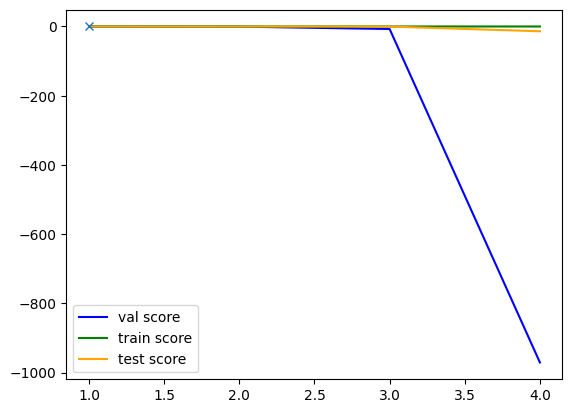

In [61]:
_ = plt.plot(degree,val_scores, label="val score", color="blue")
_ = plt.plot(degree, train_scores, label="train score", color="g")
_ = plt.plot(degree, test_scores, label="test score", color="orange")
_ = plt.plot([best_degree], [best_val_score], marker="x")
plt.legend()

Best degree:  1 
Val score:  0.03220458825429281
Test score: 0.04358798265457153


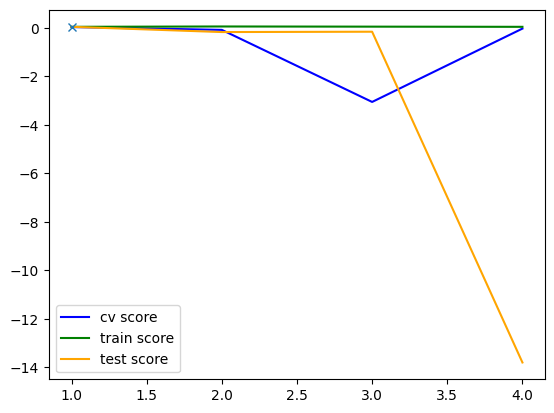

In [62]:
#Cross validation

r2_scorer = make_scorer(r2_score, greater_is_better=True)

degree = list(range(1,5))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train_small, y_train, scoring=r2_scorer, cv=3)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores) #this to identify the best model, with the highest score
best_degree = degree[best_model_idx] #this is to save the degree of the best model
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)


# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small
model = model.fit(X_train_small, y_train_small)
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Test score:", test_score)

_ = plt.plot(degree, val_scores, label="cv score", color="blue")
_ = plt.plot(degree, train_scores, label="train score", color="green")
_ = plt.plot(degree, test_scores, label="test score", color="orange")
_ = plt.plot([best_degree], [best_val_score], marker="x")
plt.legend()

In [63]:
#gridSearchCV to perform cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}
#'linear__fit_intercept': [True, False],
#'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=3, refit=True)
cv.fit(X_train_small, y_train_small)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score, response_method='predict'))

In [64]:
pd.DataFrame(cv.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001487      0.000160         0.000698        0.000053   
1       0.001838      0.000166         0.000742        0.000028   
2       0.003140      0.000419         0.001166        0.000019   
3       0.028761      0.025177         0.002673        0.001018   

   param_poly__degree               params  split0_test_score  \
0                   1  {'poly__degree': 1}           0.036491   
1                   2  {'poly__degree': 2}           0.024293   
2                   3  {'poly__degree': 3}           0.047787   
3                   4  {'poly__degree': 4}           0.036541   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.027351           0.032771         0.032205        0.003753   
1           0.026173          -0.302927        -0.084154        0.154698   
2           0.025948          -9.246536        -3.057601        4.376247   
3           0.019020          -0.149798        -0.031412        0.084016   

   rank_test_score  
0                1  
1                3  
2                4  
3                2

In [65]:
# Retrieve the best trainedestimator
cv.best_estimator_
# Retrieve its parameters
cv.best_params_
# Retrieve the best **CV** score
# I.e., mean of the scores on each fold
cv.best_score_
print(cv.best_params_, ' ', cv.best_score_)

{'poly__degree': 1}   0.03220458825429281


In [66]:
model = cv.best_estimator_
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train score:", cv.best_score_)
print("Test score:", test_score)

Best degree: 1
Train score: 0.03220458825429281
Test score: 0.04358798265457153


In [67]:
#best feature subset selection
# Convert back from numpy arrays to data frames
# just for convenience, since we can use names to
# index features
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

In [68]:
#creation of subsets
import itertools
def get_subsets(X_pd, dim):
    feature_names = X_pd.columns.tolist()
    # Compute all possible combinations of 'dim' values
    subset_names = itertools.combinations(feature_names, dim) # list of list of names [[name of first candidate, ...], [...]]
    # Convert names into datasets
    data_subsets = [X_pd[list(fnames)] for fnames in subset_names] #For each combination of feature names, it selects the corresponding columns from the original DataFrame X_pd, effectively creating subsets of the original data.
    return data_subsets

subsets = get_subsets(X_train_pd, 2)
subsets[0].head() # training set of the first subset
subsets[1].head() # training set of the second subset

DNAtype  Ncodons
0      0.0   4273.0
1      0.0  14830.0
2      0.0   2438.0
3      2.0   1011.0
4      1.0   1035.0

Subset selection

In [69]:
def subset_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                     candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                     subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                     test_evaluator=None, test_argbest=None, # Metric to be used on the test set
                     candidates_scorer_name=None,  # Name of 2. figure
                     subsets_scorer_name=None,     # Name of 3. figure
                     verbose=True, weight_step3=0):
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest

    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A counter to keep track of the total number of trials

    # 1. and 2. Evaluate all Mk candidates with
    #           k=0...P features
    #Loop over the range of the number of features.
    #For each dimension, generate subsets of features using get_subsets.
    #Train models on each subset (if not empty), evaluate them using candidates_evaluator, and keep track of metrics.
    #Select the best candidate for each dimension using candidates_argbest.
    #Compute the metric for step 3 using the selected best candidate.
    # =========================================
    #cambiato sennò crashava
    for dim in range(3): #gr through all the numbers of features
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models

        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        dim_subsets = get_subsets(X_train_pd, dim)
        for Xtrain_sub in dim_subsets:

            # Train the model on the subset
            if Xtrain_sub.shape[-1] == 0:
                # 1. Train the M0 model if the number of
                #    features is zero!
                # ======================================
                model = DummyRegressor()
            else:
                model = LinearRegression(fit_intercept=True)

            model, score = candidates_evaluator(model, Xtrain_sub, ytrain) #train the model and perfrom the evaluatiom
            candidate_models.append(model) #we collect all the models and scores
            candidate_metrics.append(score)
            num_evaluations += 1

        _ = candidate_fig.scatter([dim]*len(candidate_metrics), candidate_metrics,
                                  color="b") #plotting the scores of all the models

        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Save best candidate features
        best_features = candidate_models[idx_best_candidate]
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        subsets_best_features.append(best_features)

        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = dim_subsets[idx_best_candidate]
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_subset_Xtrain.columns.tolist()]
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += 0

        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))

    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]

    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)

    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()

    # Plot a figure to show how the 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                            marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                            marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()


In [70]:
#This code defines a function get_evaluator that takes a scorer function as input and returns another function called evaluator.
#The purpose of get_evaluator is to create an "evaluator" function that can apply the provided scorer to evaluate models.
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False): #nested function that takes a model, X, y, and an optional trained parameter. The trained parameter is used to indicate if the model has already been trained.
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator

............
Best model (M0) with 0 features: DummyRegressor()
M0 subset score (3.): 12.400029182434082
............
Best model (M1) with 1 features: LinearRegression()
M1 subset score (3.): 10.45365047454834
............
Best model (M2) with 2 features: LinearRegression()
M2 subset score (3.): 8.90422248840332


Best configuration has 2 features
Features: LinearRegression()
Total number of trained models: 2279


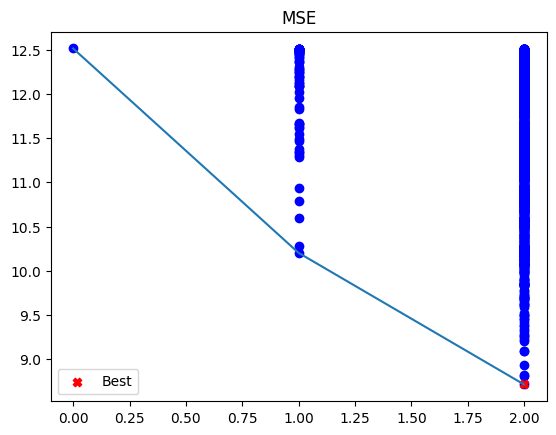

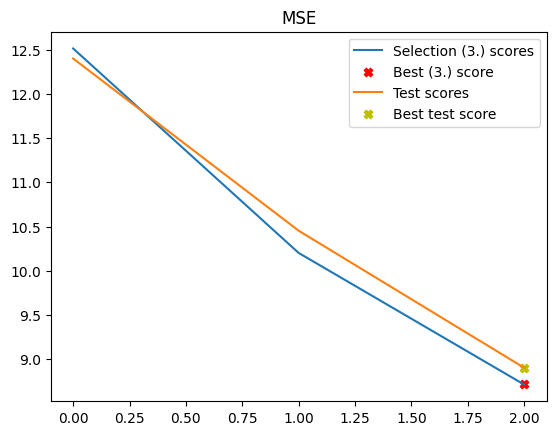

In [71]:
subset_selection(X_train_pd, y_train, X_test_pd, y_test,
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin,
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin,
                 candidates_scorer_name="MSE",
                 subsets_scorer_name="MSE",
                 verbose=True)



Best configuration has 2 features
Features: LinearRegression()

Sigma scorer

In [72]:
def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))


............
Best model (M0) with 0 features: DummyRegressor()
M0 subset score (3.): 12.400029182434082
............
Best model (M1) with 1 features: LinearRegression()
M1 subset score (3.): 10.45365047454834
............
Best model (M2) with 2 features: LinearRegression()
M2 subset score (3.): 8.90422248840332


Best configuration has 2 features
Features: LinearRegression()
Total number of trained models: 2279


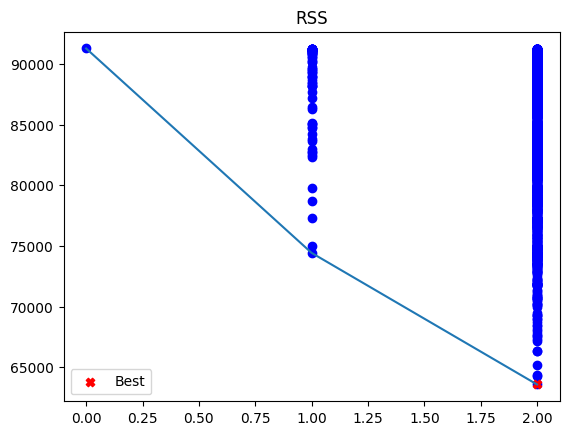

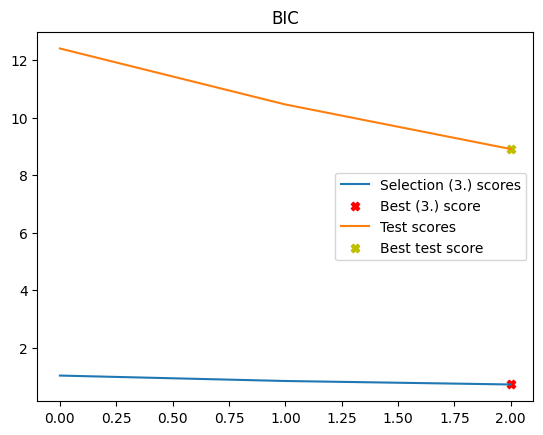

In [73]:
def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)

    return scorer

sigma = estimate_sigma(X_train_pd, y_train)
subset_selection(X_train_pd, y_train, X_test_pd, y_test,
                 get_evaluator(make_scorer(rss)), np.argmin, # 2.
                 get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                 candidates_scorer_name="RSS",
                 subsets_scorer_name="BIC",
                 verbose=True)

Forward selection

In [74]:
#forward selection

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest

    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials

    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns


    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)

    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models

        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)

        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1

        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")

        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)

        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3

        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))

    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]

    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)

    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()

    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                            marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                            marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M0) with 1 features: ['GCG']
M0 subset score (3.): 0.8397802931405925
............
Best model (M1) with 2 features: ['GCG', 'CCC']
M1 subset score (3.): 0.7187041941488311
............
Best model (M2) with 3 features: ['GCG', 'CCC', 'UGU']
M2 subset score (3.): 0.6705622658985455
............
Best model (M3) with 4 features: ['GCG', 'CCC', 'UGU', 'CCA']
M3 subset score (3.): 0.6194963337575691
............
Best model (M4) with 5 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA']
M4 subset score (3.): 0.5975687720156525
............
Best model (M5) with 6 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA', 'GGC']
M5 subset score (3.): 0.5791399273139941
............
Best model (M6) with 7 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA', 'GGC', 'UUA']
M6 subset score (3.): 0.5573685653705011
............
Best model (M7) with 8 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA', 'GGC', 'UUA', 'CUU']
M7 subset score (3.): 0.5443319806585436
............
Best model (M8) with 9 features

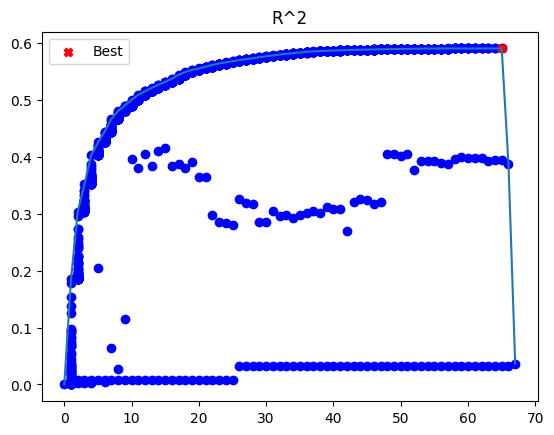

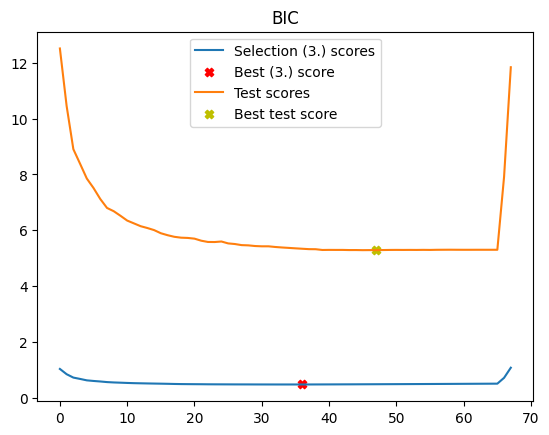

In [75]:
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="BIC",
                  verbose=True)

forward feature selection with cross validation

............
Best model (M0) with 1 features: ['GCG']
M0 subset score (3.): 0.18453456163406373
............
Best model (M1) with 2 features: ['GCG', 'CCC']
M1 subset score (3.): 0.30311196446418764
............
Best model (M2) with 3 features: ['GCG', 'CCC', 'UGU']
M2 subset score (3.): 0.3502687692642212
............
Best model (M3) with 4 features: ['GCG', 'CCC', 'UGU', 'CCA']
M3 subset score (3.): 0.40030959248542786
............
Best model (M4) with 5 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA']
M4 subset score (3.): 0.42249500155448916
............
Best model (M5) with 6 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA', 'GGC']
M5 subset score (3.): 0.44130865931510926
............
Best model (M6) with 7 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA', 'GGC', 'UUA']
M6 subset score (3.): 0.4633838474750519
............
Best model (M7) with 8 features: ['GCG', 'CCC', 'UGU', 'CCA', 'GAA', 'GGC', 'UUA', 'CUU']
M7 subset score (3.): 0.4772427022457123
............
Best model (M8) with 9 fea

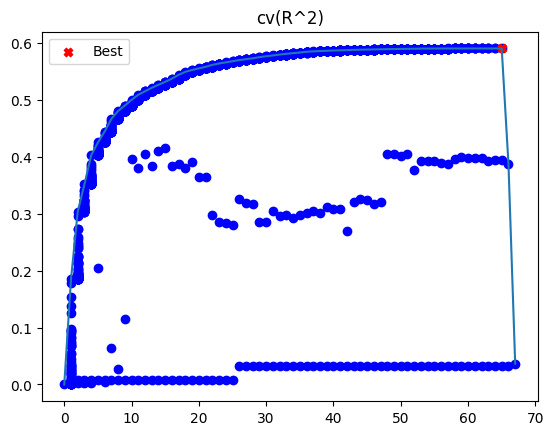

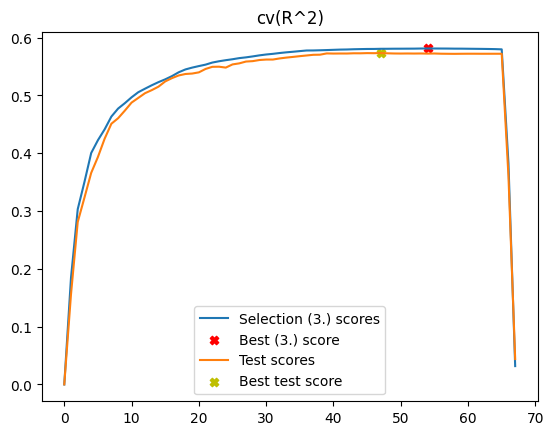

In [76]:
#forward feature selection with cross validation
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y,
                                                                      test_size=val_size,
                                                                      random_state=mpg_test_seed)

        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val)

        return model, score

    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)

    return evaluator


cv = 10
sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score), cv=cv), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

End of feature selection and model evaluation

# 4. Recover AGA codon frequency
Use the regression model trained at the previous step to recover the AGA
codon frequency, by predicting the AGA value of each test sample. Deter-
mine if the test performance of the best model found at step (2.) improves
if the AGA frequency values are also used for prediction.

In [77]:
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

# Remove the first column
test_data.drop(columns=test_data.columns[0], axis=1, inplace=True)
train_data.drop(columns=train_data.columns[0], axis=1, inplace=True)

label_encoder = LabelEncoder()
train_data['Kingdom'] = label_encoder.fit_transform(train_data['Kingdom'])
# Identify feature columns and target column ('AGA' in this case)

# Select features and target for training the AGA predictor
X = train_data.drop(columns=['AGA', 'Kingdom', 'DNAtype','SpeciesID','Ncodons','SpeciesName']).to_numpy()
y = train_data['AGA'].to_numpy()

test_set = test_data.drop(["DNAtype", "SpeciesID", "Ncodons", "SpeciesName", "Kingdom"], axis = 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
test2 = scaler.transform(test_set)

model = LinearRegression()
model.fit(X, y)
# Predict AGA frequency on the test dataset
aga_predictions = model.predict(test2)

aga_predictions_df = pd.DataFrame({'Predicted_AGA': aga_predictions})

/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [78]:
test = pd.read_csv('test.csv')
aga_predictions_df = pd.DataFrame({'AGA': aga_predictions})
test_with_AGA = pd.concat([test, aga_predictions_df], axis=1)

In [79]:
# Encode the target variable 'Kingdom' in the training set
# Combine classes from both train and test sets for encoding
train = pd.read_csv('train.csv')

train['Kingdom'] = train['Kingdom'].astype(str)
test_with_AGA['Kingdom'] = test_with_AGA['Kingdom'].astype(str)

# Combine unique classes from both train and test sets
all_classes = np.unique(np.concatenate((train['Kingdom'], test_with_AGA['Kingdom'])))

# Encode the target variable 'Kingdom' using all classes
label_encoder = LabelEncoder()
label_encoder.fit(all_classes)

# Encode the 'Kingdom' column in both train and test sets
train['Kingdom'] = label_encoder.transform(train['Kingdom'])
test_with_AGA['Kingdom'] = label_encoder.transform(test_with_AGA['Kingdom'])

# Separate features and target variable in the training set
X_train = train.drop(columns=['Unnamed: 0', 'Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName'])
y_train = train['Kingdom']

# Separate features and target variable in the test set
X_test = test_with_AGA.drop(columns=['Unnamed: 0', 'Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName'])
y_test = test_with_AGA['Kingdom']

In [80]:
# Convert categorical columns to numerical using pd.get_dummies
X_train_dummies = pd.get_dummies(X_train, drop_first=True)
X_test_dummies = pd.get_dummies(test_with_AGA, drop_first=True)

# Handle missing values
X_train_dummies = X_train_dummies.fillna(X_train_dummies.mean())
X_test_dummies = X_test_dummies.fillna(X_test_dummies.mean())

# Align the test set columns with the training set columns
X_test_dummies = X_test_dummies.reindex(columns=X_train_dummies.columns, fill_value=0)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dummies)
X_test_scaled = scaler.transform(X_test_dummies)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Binarize the labels for multi-class ROC curve
y_train_bin = label_binarize(y_train_encoded, classes=np.unique(y_train_encoded))
y_test_bin = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))

In [81]:
model = SVC(random_state=42)
model.fit(X_train_scaled, y_train_encoded)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9179
Precision: 0.9162
Recall: 0.9179
F1-score: 0.9144


/home/elena/Desktop/ML-project0/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy increased from 0.90 (old data) to 0.9179 (new data).
Precision and recall both slightly improved when the AGA frequency was included.
The F1 score also improved from 0.81/0.89 to 0.9144.
This indicates that adding the AGA codon frequency as a feature to the regression model has improved its predictive performance.

The inclusion of the AGA codon frequency in the model improved its test performance significantly across all key metrics (accuracy, precision, recall, and F1-score). This suggests that AGA frequency is a valuable feature for improving the predictive capability of the model, possibly because it captures some underlying biological or statistical patterns that were not accounted for in the original feature set.
